<a href="https://colab.research.google.com/github/arpanbiswas52/MOBO_PhysicsBasedModels/blob/main/PhysicsDriven_MOBO_(FerroSim)_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>PhysicsDriven MOBO (FerroSim) tutorial

-- Aug 26, 2021

prepared by **Arpan Biswas**

This notebook provides the codes of **physics driven MOBO**. This is part 4 of the notebook.

Here we illustrate,

-- MOBO implementation to another physics based complex model -- FerroSim Model, developed by **Rama Vasudevan**

User can look into the FerroSim model here: https://github.com/ramav87/FerroSim




<h1> Physics based Numerical Model

Ferrosim Model - developed by Rama Vasudevan

In [1]:
#@title Installations
!pip install git+https://github.com/ramav87/FerroSim.git

  Cloning https://github.com/ramav87/FerroSim.git to /tmp/pip-req-build-8ibka5i9
  Running command git clone -q https://github.com/ramav87/FerroSim.git /tmp/pip-req-build-8ibka5i9
  Created wheel for FerroSim: filename=FerroSim-0.0.1-py3-none-any.whl size=6059 sha256=0f4b089d3ceb70f72eedb5e7be50e57a06e05e407a511b565da4ff91c5c1904c
  Stored in directory: /tmp/pip-ephem-wheel-cache-cbfa623l/wheels/a3/cf/a5/e75b66abcad38f13ac2ffe7d2dd58dd6a290905bb77615463f
Successfully built FerroSim


Install Packages

In [2]:
!pip install botorch #version 0.5.0
!pip install gpytorch #version 1.5.0
!pip install pymoo #version 0.4.2.2
!pip install atomai #version 0.7.2 (Optional)

     |████████████████████████████████| 475 kB 4.3 MB/s 
     |████████████████████████████████| 498 kB 41.5 MB/s 
     |████████████████████████████████| 3.7 MB 4.3 MB/s 
     |████████████████████████████████| 239 kB 51.5 MB/s 
  Created wheel for pymoo: filename=pymoo-0.4.2.2-cp37-cp37m-linux_x86_64.whl size=4940009 sha256=e64c8fbdb7554235fa5a49bcaaa4514a1ecf4b4c7fa99a87a1c1082651379cf8
  Stored in directory: /root/.cache/pip/wheels/ab/8c/89/c450ad360fc24cb70fec0388e8d95b51021eae5dab248ab76e
Successfully built pymoo
     |████████████████████████████████| 143 kB 4.2 MB/s 
     |████████████████████████████████| 193 kB 53.7 MB/s 
     |████████████████████████████████| 865 kB 44.7 MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174982 sha256=492582df8b42423c8c972b7d6fa97a53221452df7ca189a20c0e4d24eac93299
  Stored in directory: /root/.cache/pip/wheels/f4/4e/dd/06777c90710ce1766376ecc87979967fe69ff3affc29c0b530
Successfully built mendeleev


Import functions

In [3]:
#Import classical numpy and torch
import torch as to
import numpy as np
#Plotting
import matplotlib.pyplot as plt
#Random # generator
import random

# Import pymoo package for MOO optimization using NGSA-2 (comparison with MOBO)
import pymoo
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

#Optional for making movies
import atomai as aoi

# Import GP and BoTorch functions
import gpytorch as gpt
from botorch.models import SingleTaskGP, ModelListGP
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from botorch import fit_gpytorch_model
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.sampling import IIDNormalSampler
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.constraints import GreaterThan
from gpytorch.models import ExactGP

# Specific for MOBO
from botorch.generation import get_best_candidates, gen_candidates_torch
from botorch.optim import gen_batch_initial_conditions
from botorch.utils.transforms import unnormalize
from botorch.utils.sampling import draw_sobol_samples
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
# for qEIHV acquistion function (Posteriori method)
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
# for qParEGO acquisition function (Prioiri method)
from botorch.utils.sampling import sample_simplex #This defines weights to objectives randomly
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
# Important functions for MOBO- select non-dominated Pareto solutions and compute hypervolume
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume

#Import optimizer algorithm to train GP hyperparameters
from torch.optim import SGD
from torch.optim import Adam


#Import functions from ferrosim model
from ferrosim import Ferro2DSim

#other math functions
from scipy.stats import norm

<h1> Now, we define classes/functions for MOBO architecture

Below section defines the list of functions (user calls these functions during analysis):
1. Gaussian Process
2. Optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
3. Posterior means and variance computation
4. Acquistion functions for MOBO- qEIHV and qParEGO

GP models are configured using GPyTorch package and to handle multiple independent GP models (for individual objectives), we utilize multi-output GP function, ModelListGP

To initialize the computation of the acquisition function, we select 20 restart initial locations for a set of 1000 random points, and considered maximum iterations of 200. The acquisition function is approximated using 500 Monte-Carlo (MC) based samples. 

In [4]:
#########################Gaussian Process########################

class SimpleCustomGP(ExactGP, GPyTorchModel):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        ## Here we use constant mean, user can change here with different mean function
        self.mean_module = ConstantMean()
        ## Here we use Radial Basis function kernel, user can change here with different kernel function
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

############## Optimize Hyperparameters of GP##############################
def optimize_hyperparam_trainGP(train_X_norm, train_Y_norm):
    # Gp model fit

    gp_surro1 = SimpleCustomGP(train_X_norm, train_Y_norm[:, 0])
    gp_surro2 = SimpleCustomGP(train_X_norm, train_Y_norm[:, 1])
    gp_surro = ModelListGP(gp_surro1, gp_surro2)
    gp_surro = gp_surro.double()
    gp_surro.likelihood.likelihoods[0].noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
    gp_surro.likelihood.likelihoods[1].noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
    mll1 = ExactMarginalLogLikelihood(gp_surro.likelihood.likelihoods[0], gp_surro.models[0])
    mll2 = ExactMarginalLogLikelihood(gp_surro.likelihood.likelihoods[1], gp_surro.models[1])
    # fit_gpytorch_model(mll)
    mll1 = mll1.to(train_X_norm)
    mll2 = mll2.to(train_X_norm)
    gp_surro.models[0].train()
    gp_surro.likelihood.likelihoods[0].train()
    gp_surro.models[1].train()
    gp_surro.likelihood.likelihoods[1].train()
    ## Here we use Adam optimizer with learning rate =0.2, user can change here with different algorithm and/or learning rate for each GP
    optimizer1 = Adam([{'params': gp_surro.models[0].parameters()}], lr=0.2)
    optimizer2 = Adam([{'params': gp_surro.models[1].parameters()}], lr=0.2)

    NUM_EPOCHS = 150

    for epoch in range(NUM_EPOCHS):
        # clear gradients
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        # forward pass through the model to obtain the output MultivariateNormal
        output1 = gp_surro.models[0](train_X_norm)
        output2 = gp_surro.models[1](train_X_norm)
        # Compute negative marginal log likelihood
        loss1 = - mll1(output1, gp_surro.models[0].train_targets)
        loss2 = - mll2(output2, gp_surro.models[1].train_targets)
        # back prop gradients
        loss1.backward(retain_graph=True)
        # back prop gradients
        loss2.backward(retain_graph=True)
        # print last iterations
        if (epoch + 1) > NUM_EPOCHS: #Stopping the print for now
            print("GP Model trained:")
            print("Iteration:" + str(epoch + 1))
            print("Loss for ob1:" + str(loss1.item()))
            print("Loss for ob2:" + str(loss2.item()))
            # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
            print("noise for obj1:" + str(gp_surro.likelihood.likelihoods[0].noise.item()))
            print("noise for obj2:" + str(gp_surro.likelihood.likelihoods[1].noise.item()))

        optimizer1.step()
        optimizer2.step()

    gp_surro.models[0].eval()
    gp_surro.likelihood.likelihoods[0].eval()
    gp_surro.models[1].eval()
    gp_surro.likelihood.likelihoods[1].eval()
    return gp_surro

##########################GP posterior predictions#############################
def cal_posterior(gp_surro, testX1_norm, testX2_norm, t_y, num_rows):
    y_pred_means = to.empty(num_rows, num_rows, 2)
    y_pred_vars = to.empty(num_rows, num_rows, 2)
    for t1, (x1, x2, y1, y2) in enumerate(zip(testX1_norm, testX2_norm, t_y[:, :, 0], t_y[:, :, 1])):
        for t2, (xx1, xx2, yy1, yy2) in enumerate(zip(x1, x2, y1, y2)):

            if (xx1 == -1 and xx2 == -1):
                y_pred_means[t1, t2, 0] = yy1
                y_pred_vars[t1, t2, 0] = 1e-8
                y_pred_means[t1, t2, 1] = yy2
                y_pred_vars[t1, t2, 1] = 1e-8
            else:
                test_X = to.empty(1, 2)
                test_X[:, 0] = xx1
                test_X[:, 1] = xx2
                test_X = test_X.double()
                with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
                     gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False,
                                                    solves=True), \
                     gpt.settings.max_cg_iterations(100), \
                     gpt.settings.max_preconditioner_size(80), \
                     gpt.settings.num_trace_samples(128):
                    y1_pred_surro, y2_pred_surro = gp_surro.models[0].posterior(test_X), gp_surro.models[1].posterior(test_X)
                    y_pred_means[t1, t2, 0] = y1_pred_surro.mean
                    y_pred_vars[t1, t2, 0] = y1_pred_surro.variance
                    y_pred_means[t1, t2, 1] = y2_pred_surro.mean
                    y_pred_vars[t1, t2, 1] = y2_pred_surro.variance

    return y_pred_means, y_pred_vars


########## MOBO acquisition function ###########################
# q-Expected Improvement acquistion function ###########
def optimize_qehvi(model, train_X, train_obj, rf, BATCH_SIZE):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    sampler = SobolQMCNormalSampler(num_samples=500, seed=0, resample=False)
    #BATCH_SIZE = 4
    partitioning = NondominatedPartitioning(ref_point=rf, Y=train_obj)
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=rf.tolist(),  # use known reference point
        partitioning=partitioning,
        sampler=sampler,
    )
    # optimize
    new_x, value = optimize_acqf(
        acq_function=acq_func,
        bounds=to.tensor([[0.0] * 2, [1.0] * 2]),
        q=BATCH_SIZE,
        num_restarts=20,
        raw_samples=1000,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200, "nonnegative": True},
        sequential=True,
    )


    return new_x, value

# q-PAREGO acquistion function ###########
def optimize_qparego(model, train_X, train_obj, BATCH_SIZE):
    """Samples a set of random weights for each candidate in the batch, performs sequential greedy optimization
    of the qParEGO acquisition function, and returns a new candidate and observation."""
    sampler = SobolQMCNormalSampler(num_samples=500, seed=0, resample=False)
    #BATCH_SIZE = 4
    acq_func_list = []
    for _ in range(BATCH_SIZE):
        n_obj = train_obj.dim()
        weights = sample_simplex(n_obj, **tkwargs).squeeze()
        objective = GenericMCObjective(get_chebyshev_scalarization(weights=weights, Y=train_obj))
        acq_func = qExpectedImprovement(  # pyre-ignore: [28]
            model=model,
            objective=objective,
            best_f=objective(train_obj).max(),
            sampler=sampler,
        )
        acq_func_list.append(acq_func)
    # optimize
    new_x, value = optimize_acqf_list(
        acq_function_list=acq_func_list,
        bounds=to.tensor([[0.0] * 2, [1.0] * 2]),
        num_restarts=20,
        raw_samples=1000,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )


    return new_x, value




<h1>Define objective functions from FerroSim model

Here we considered to define two set of multi-objectives

1. Loop area and switchable polarization
2. Loop area and reach to target switchable polarization

Here, in this cell, user can add other sets of multi-objective functions as needed

In [5]:
###########Multi-objective1: Loop area and Switchable Polarization###################
def cal_objective1(lattice_size, random_field, def_num, rTip):
    sim = Ferro2DSim(n=lattice_size, defect_number=def_num, rfield_strength=random_field, rTip=rTip)
    results = sim.runSim()
    l_area = ((sim.results['Polarization'][375:625]-sim.results['Polarization'][125:375]).sum())/(100*250)
    switch_P = (sim.results['Polarization'][500] - sim.results['Polarization'][250])/100

    return l_area, switch_P

###########Multi-objective1: Loop area and Reach to target Switchable Polarization###################
def cal_objective2(lattice_size, random_field, def_num, rTip):
    sim = Ferro2DSim(n=lattice_size, defect_number=def_num, rfield_strength=random_field, rTip=rTip)
    results = sim.runSim()
    l_area = ((sim.results['Polarization'][375:625]-sim.results['Polarization'][125:375]).sum())/(100*250)
    switch_P = (sim.results['Polarization'][500] - sim.results['Polarization'][250])/100
    target_switchP = 1.5
    tol_switchP = 0.05*target_switchP
    dist_target= np.exp((-(switch_P-target_switchP)**2)/tol_switchP**2)

    return l_area, dist_target

Other list of functions-

1. Evaluate initial data and normalize all data
2. Evaluate functions for new data and augment data

**These functions integrates with the physics-based models (eg. FerroSim) and  call the function evaluations (previous defined multi-function objectives) as prior knowledge to MOBO.**

Here, user can replace with new defined function evaluations or any other physics based models (showed in-code where to make appropiate changes)

In [6]:
# Normalize all data. It is very important to fit GP model and MOBO exploration with normalized data to avoid issues such as
# - decrease of GP performance due to largely spaced real-valued data X, over-weighting on higher valued objectives Y in acquistion function computation.
def normalize_get_initialdata_ferroSim(X1, X2, test_X1, test_X2, num_rows, num, problem, obj2, m):
    # Normalize X
    minX1 = min(X1)
    maxX1 = max(X1)
    minX2 = min(X2)
    maxX2 = max(X2)
    Xmin = np.hstack((minX1, minX2))
    Xmax = np.hstack((maxX1, maxX2))
    X1, X2 = np.meshgrid(X1, X2)
    test_X1, test_X2 = np.meshgrid(test_X1, test_X2)
    X1_norm = (X1 - Xmin[0]) / (Xmax[0] - Xmin[0])
    X2_norm = (X2 - Xmin[1]) / (Xmax[1] - Xmin[1])
    testX1_norm = (test_X1 - Xmin[0]) / (Xmax[0] - Xmin[0])
    testX2_norm = (test_X2 - Xmin[1]) / (Xmax[1] - Xmin[1])

    # Select starting samples randomly as training data
    testX1_norm = np.reshape(testX1_norm, (num_rows ** 2, 1))
    testX2_norm = np.reshape(testX2_norm, (num_rows ** 2, 1))
    test_X1 = np.reshape(test_X1, (num_rows ** 2, 1))
    test_X2 = np.reshape(test_X2, (num_rows ** 2, 1))
    np.random.seed(10)
    ind_start = np.random.choice(len(testX1_norm) - 1, size=num, replace=False)
    train_X = np.zeros((num, 2))
    train_X_norm = np.zeros((num, 2))
    train_y = np.zeros((num, 2))
    t_y = np.zeros((num_rows ** 2, 2))
    m = 0
    print("Function evaluaton for initial randomly selected samples")
    for i in range(0, num):
        train_X_norm[i, 0] = testX1_norm[ind_start[i]]
        train_X_norm[i, 1] = testX2_norm[ind_start[i]]
        train_X[i, 0] = test_X1[ind_start[i]]
        train_X[i, 1] = test_X2[ind_start[i]]
        print("Function eval #" + str(m + 1))
        ################# Here we integrate the functionalities from physics driven decision tree (prior physics based knowledge) with classical MOBO-- physics driven MOBO
        #Function evaluation is done by calling the functions 'cal_objective1 or cal_objective2' where input arguments are lattice_size, random_field, def_num, rTip.
        # Output arguments for cal_objective1: loop area (function 1) and switchable polarization (function 2). Both are scalar values
        # Output arguments for cal_objective2: loop area (function 1) and reach to target switchable polarization =1.5 (function 2). Both are scalar values
        # Here, user can replace with any other physics based models or add new objectives of ferrosim model
        if (obj2 == "switch_P"):
           LA, SP = cal_objective1(10, train_X[i, 0], int(train_X[i, 1]), rTip=3)
        else:
           LA, SP = cal_objective2(10, train_X[i, 0], int(train_X[i, 1]), rTip=3)

        if (problem[0] == 'min'):
            train_y[i, 0] = -LA  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
            t_y[ind_start[i], 0] = -LA  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        else:
            train_y[i, 0] = LA
            t_y[ind_start[i], 0] = LA

        if (problem[1] == 'min'):
            train_y[i, 1] = -SP  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
            t_y[ind_start[i], 1] = -SP  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        else:
            train_y[i, 1] = SP
            t_y[ind_start[i], 1] = SP

        # testX1_norm[ind_start[i]] =-1
        # testX2_norm[ind_start[i]] =-1
        m = m + 1

    testX1_norm = np.reshape(testX1_norm, (num_rows, num_rows))
    testX2_norm = np.reshape(testX2_norm, (num_rows, num_rows))
    t_y = np.reshape(t_y, (num_rows, num_rows, 2))

    # Convert to torch
    train_X_norm = to.from_numpy(train_X_norm)
    train_X_norm = train_X_norm.double()
    train_Y = to.from_numpy(train_y)
    # Normalize Y
    testY1_norm = (train_Y[:, 0] - train_Y[:, 0].min()) / (train_Y[:, 0].max() - train_Y[:, 0].min())
    testY2_norm = (train_Y[:, 1] - train_Y[:, 1].min()) / (train_Y[:, 1].max() - train_Y[:, 1].min())
    train_Y_norm = to.empty(train_Y.__len__(), 2)
    train_Y_norm[:, 0] = testY1_norm
    train_Y_norm[:, 1] = testY2_norm

    return X1_norm, X2_norm, testX1_norm, testX2_norm, train_X, train_X_norm, train_Y, train_Y_norm, Xmin, Xmax, t_y, m


################################Augment data - Existing training data with new evaluated data################################
def augment_newdata_ferroSim(acq_X, train_X, train_X_norm, train_Y, Xmin, Xmax, BATCH_SIZE, num_rows, problem, obj2, m):
    nextX_norm = acq_X
    nextX = nextX_norm * (to.from_numpy(Xmax) - to.from_numpy(Xmin)) + to.from_numpy(Xmin)
    nextX = nextX.detach().numpy()
    train_X_norm = to.cat((train_X_norm, nextX_norm), 0)
    train_X_norm = train_X_norm.double()
    train_X = np.vstack((train_X, nextX))
    next_feval = to.empty(BATCH_SIZE, 2)
    print("Batch Function eval #" + str(m + 1))

    for j in range(0, BATCH_SIZE):
        # Function evaluation for new data
        print("Within batch: Function eval: " + str(j + 1) + " of " + str(BATCH_SIZE))
        ################# Here we integrate the functionalities from physics driven decision tree (prior physics based knowledge) with classical MOBO-- physics driven MOBO
        #Function evaluation is done by calling the functions 'cal_objective1 or cal_objective2' where input arguments are lattice_size, random_field, def_num, rTip.
        # Output arguments for cal_objective1: loop area (function 1) and switchable polarization (function 2). Both are scalar values
        # Output arguments for cal_objective2: loop area (function 1) and reach to target switchable polarization =1.5 (function 2). Both are scalar values
        # Here, user can replace with any other physics based models or add new objectives of ferrosim model
        if (obj2 == "switch_P"):
           LA, SP = cal_objective1(10, nextX[j, 0], int(nextX[j, 1]), rTip=3)
        else:
           LA, SP = cal_objective2(10, nextX[j, 0], int(nextX[j, 1]), rTip=3)

        if (problem[0] == 'min'):
            next_feval[j, 0] = -LA # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        else:
            next_feval[j, 0] = LA
        if (problem[1] == 'min'):
            next_feval[j, 1] = -SP # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        else:
            next_feval[j, 1] = SP

    train_Y = to.cat((train_Y, next_feval), 0)
    # Normalize Y
    testY1_norm = (train_Y[:, 0] - train_Y[:, 0].min()) / (train_Y[:, 0].max() - train_Y[:, 0].min())
    testY2_norm = (train_Y[:, 1] - train_Y[:, 1].min()) / (train_Y[:, 1].max() - train_Y[:, 1].min())
    train_Y_norm = to.empty(train_Y.__len__(), 2)
    train_Y_norm[:, 0] = testY1_norm
    train_Y_norm[:, 1] = testY2_norm
    m = m + 1
    return train_X, train_X_norm, train_Y, train_Y_norm, m

Functions to select non-dominated Pareto solutions and compute Hypervolume

**These are important functions in the MOBO setting**

In [7]:
################## compute pareto front###################
def select_Pareto(train_Y_norm, train_X_norm, train_Y, train_X):
    pareto_mask_norm = is_non_dominated(train_Y_norm)
    pareto_y_norm = train_Y_norm[pareto_mask_norm]
    pareto_x_norm = train_X_norm[pareto_mask_norm]
    pareto_mask = is_non_dominated(train_Y)
    pareto_y = train_Y[pareto_mask]
    pareto_x = train_X[pareto_mask]
    return pareto_y_norm, pareto_x_norm, pareto_y, pareto_x

###################compute hypervolume###########################
def calHV(rf, pareto_y_norm):
    hv = Hypervolume(ref_point=rf)
    volume = hv.compute(pareto_y_norm)
    return volume

Plots for iterative individual predicted functions and non-dominated Pareto Solutions, final Pareto frontier in multi-objective and multi-parameter space

**This is an important plotting function where user will understand the building of Pareto frontier for a given problem, and the user can adust images based on their convinience**

In [8]:
######################################### Plots for prediction of individual objectives and location of selected samples

def plot_exploration_results(X1, X2, Gp_y_mu, Gp_y_var, train_X, train_Y, iter, param1, param2, obj1, obj2, problem):
    if (problem[0]=='min'): #Transform to original function value
        Gp_y_mu[:, :, 0] = -Gp_y_mu[:, :, 0]
        train_Y[:,0] = -train_Y[:,0]
    if (problem[1]=='min'): #Transform to original function value
        Gp_y_mu[:, :, 1] = -Gp_y_mu[:, :, 1]
        train_Y[:,1] = -train_Y[:,1]

    _, ax = plt.subplots(3, 2, figsize=(12, 15))
    ax[0, 0].imshow(X1, origin='bottom', cmap='viridis')
    ax[0, 1].imshow(X2, origin='bottom', cmap='viridis')
    ax[1, 0].imshow(Gp_y_mu[:, :, 0].detach().numpy(), origin='bottom', cmap='viridis')
    ax[1, 1].imshow(Gp_y_var[:, :, 0].detach().numpy(), origin='bottom', cmap='viridis')
    ax[2, 0].imshow(Gp_y_mu[:, :, 1].detach().numpy(), origin='bottom', cmap='viridis')
    ax[2, 1].imshow(Gp_y_var[:, :, 1].detach().numpy(), origin='bottom', cmap='viridis')
    ax[0, 0].set_title(str(param1))
    ax[0, 1].set_title(str(param2))
    ax[1, 0].set_title(str(obj1)+" (GP), iter=" + str(iter))
    ax[1, 1].set_title("Uncertainty, iter=" + str(iter))
    ax[2, 0].set_title(str(obj2)+" (GP), iter=" + str(iter))
    ax[2, 1].set_title("Uncertainty, iter=" + str(iter))
    plt.show()
    # plt.colorbar()

    #train_X = train_X.detach().numpy()
    #train_Y = train_Y.detach().numpy()
    fig1, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    ax[0].scatter(train_X[:, 0], train_X[:, 1], c=train_Y[:,0], cmap='viridis', linewidth=0.2)
    ax[0].set_xlabel(str(param1))
    ax[0].set_ylabel(str(param2))
    ax[0].set_title(str(obj1)+" (cmap), iter=" + str(iter))
    ax[1].scatter(train_X[:, 0], train_X[:, 1], c=train_Y[:,1], cmap='viridis', linewidth=0.2)
    ax[1].set_xlabel(str(param1))
    #ax[1].set_ylabel(str(param2))
    ax[1].set_title(str(obj2)+" (cmap), iter=" + str(iter))
    plt.show()

    #Retransforming for the optimization problem
    if (problem[0]=='min'): #Transform to original function value
        Gp_y_mu[:, :, 0] = -Gp_y_mu[:, :, 0]
        train_Y[:,0] = -train_Y[:,0]
    if (problem[1]=='min'): #Transform to original function value
        Gp_y_mu[:, :, 1] = -Gp_y_mu[:, :, 1]
        train_Y[:,1] = -train_Y[:,1]
    

############################### Plots for Pareto frontier formation in the normalized and real-valued objective and parameter space
def plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, n_initial, N_BO, BATCH_SIZE, param1, param2, obj1, obj2, problem):
    if (problem[0]=='min'): #Transform to original function value
        train_Y[:,0] = -train_Y[:,0]
        train_Y_norm[:,0] = -train_Y_norm[:,0]
        pareto_y[:,0] = -pareto_y[:,0]
        pareto_y_norm[:,0] = -pareto_y_norm[:,0]
    if (problem[1]=='min'): #Transform to original function value
        train_Y[:,1] = -train_Y[:,1]
        train_Y_norm[:, 1] = -train_Y_norm[:, 1]
        pareto_y[:,1] = -pareto_y[:,1]
        pareto_y_norm[:,1] = -pareto_y_norm[:,1]
    batch_number = to.cat([to.zeros(n_initial), to.arange(1, N_BO + 1).repeat(BATCH_SIZE, 1).t().reshape(-1)]).numpy()

    ## Pareto in objective space
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes[0,0].scatter(train_Y_norm[:, 0], train_Y_norm[:, 1], c= batch_number, cmap='viridis',linewidth=0.2)
    axes[0,0].set_xlabel(str(obj1))
    axes[0,0].set_xlim((-0.1, 1.1))
    axes[0,0].set_ylabel(str(obj2))
    axes[0,0].set_ylim((-0.1, 1.1))
    axes[0,0].set_title('Samples over (normalized)objective space, iter=' + str(N_BO + 1))
    axes[0,1].scatter(train_Y[:, 0], train_Y[:, 1], c= batch_number, cmap='viridis',linewidth=0.2)
    axes[0,1].set_xlabel(str(obj1))
    #axes[0,1].set_xlim((-5, 165)) #Remember to comment out the limits for running general problem. We put the limit manually for each analysis of param space for paper purpose (Comparison)
    #axes[0,1].set_ylim((-9.5, -2.5))
    #axes[0,1].set_ylabel(str(obj2))
    axes[0,1].set_title('Samples over (real)objective space, iter=' + str(N_BO + 1))
    axes[1,0].scatter(pareto_y_norm[:, 0], pareto_y_norm[:, 1], c= pareto_y_norm[:, 0], cmap='gist_rainbow',linewidth=0.2)
    axes[1,0].set_xlabel(str(obj1))
    axes[1,0].set_xlim((-0.1, 1.1))
    axes[1,0].set_ylabel(str(obj2))
    axes[1,0].set_ylim((-0.1, 1.1))
    axes[1,0].set_title('Pareto frontier over (normalized)objective space, iter=' + str(N_BO + 1))
    axes[1,1].scatter(pareto_y[:, 0], pareto_y[:, 1], c= pareto_y_norm[:, 0], cmap='gist_rainbow',linewidth=0.2)
    axes[1,1].set_xlabel(str(obj1))
    #axes[1,1].set_xlim((-5, 165)) #Remember to comment out the limits for running general problem. We put the limit manually for each analysis of param space for paper purpose (Comparison)
    #axes[1,1].set_ylim((-9.5, -2.5))
    #axes[1,1].set_ylabel(str(obj2))
    axes[1,1].set_title('Pareto frontier over (real)objective space, iter=' + str(N_BO + 1))

    ## Pareto in parameter space
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes[0,0].scatter(train_X_norm[:, 0], train_X_norm[:, 1], c= batch_number, cmap='viridis',linewidth=0.2)
    axes[0,0].set_xlabel(str(param1))
    axes[0,0].set_xlim((-0.1, 1.1))
    axes[0,0].set_ylabel(str(param2))
    axes[0,0].set_ylim((-0.1, 1.1))
    axes[0,0].set_title('Samples over over (normalized)parameter space, iter=' + str(N_BO + 1))
    axes[0,1].scatter(train_X[:, 0], train_X[:, 1], c= batch_number, cmap='viridis',linewidth=0.2)
    axes[0,1].set_xlabel(str(param1))
    #axes[0,1].set_xlim((295, 405)) #Remember to comment out the limits for running general problem. We put the limit manually for each analysis of param space for paper purpose (Comparison)
    #axes[0,1].set_ylim((3.5, 8.5))
    #axes[0,1].set_ylabel(str(param2))
    axes[0,1].set_title('Samples over over (real)parameter space, iter=' + str(N_BO + 1))
    axes[1,0].scatter(pareto_x_norm[:, 0], pareto_x_norm[:, 1], c= pareto_y_norm[:, 0], cmap='gist_rainbow',linewidth=0.2)
    axes[1,0].set_xlabel(str(param1))
    axes[1,0].set_xlim((-0.1, 1.1))
    axes[1,0].set_ylabel(str(param2))
    axes[1,0].set_ylim((-0.1, 1.1))
    axes[1,0].set_title('Pareto frontier over (normalized)parameter space, iter=' + str(N_BO + 1))
    axes[1,1].scatter(pareto_x[:, 0], pareto_x[:, 1], c= pareto_y_norm[:, 0], cmap='gist_rainbow',linewidth=0.2)
    axes[1,1].set_xlabel(str(param1))
    #axes[1,1].set_xlim((295, 405)) #Remember to comment out the limits for running general problem. We put the limit manually for each analysis of param space for paper purpose (Comparison)
    #axes[1,1].set_ylim((3.5, 8.5))
    #axes[1,1].set_ylabel(str(param2))
    axes[1,1].set_title('Pareto frontier over (real)parameter space, iter=' + str(N_BO + 1))

    #Retransforming for the optimization problem
    if (problem[0]=='min'): #Transform to original function value
        train_Y[:,0] = -train_Y[:,0]
        train_Y_norm[:,0] = -train_Y_norm[:,0]
        pareto_y[:,0] = -pareto_y[:,0]
        pareto_y_norm[:,0] = -pareto_y_norm[:,0]
    if (problem[1]=='min'): #Transform to original function value
        train_Y[:,1] = -train_Y[:,1]
        train_Y_norm[:, 1] = -train_Y_norm[:, 1]
        pareto_y[:,1] = -pareto_y[:,1]
        pareto_y_norm[:,1] = -pareto_y_norm[:,1]

    plt.show()

<h1> Physics driven MOBO framework


This function forms the Physics driven MOBO framework by integrating the earlier defined building blocks (functions) as appropiate

In [9]:
def MOBO_ferroSim(X1, X2, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem):
        ##MOBO framework#######
    m=0
    #Initialization: evaluate few initial data normalize data
    X1_norm, X2_norm, testX1_norm, testX2_norm, train_X, train_X_norm, train_Y, train_Y_norm, Xmin, Xmax, t_y, m=\
        normalize_get_initialdata_ferroSim(X1, X2, test_X1, test_X2, num_rows, num, problem, obj2, m)

    X1, X2 = np.meshgrid(X1, X2)
    test_X1, test_X2 = np.meshgrid(test_X1, test_X2)

    print("Initial evaluation complete. Start BO- acq func: " +str(acquisition))
    ## Gp model fit
    #Calling function to fit and optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
    # Input args- Torch arrays of normalized training data, parameter X and objective eval Y
    # Output args- Gaussian process model lists
    gp_surro= optimize_hyperparam_trainGP(train_X_norm, train_Y_norm)

    # compute pareto front
    pareto_y_norm, pareto_x_norm, pareto_y, pareto_x = select_Pareto(train_Y_norm, train_X_norm, train_Y, train_X)

    # compute hypervolume
    hvs = []
    rf= to.tensor([0.0] * 2)-0.001 #rf is the worst solution of the objectives. As suggested, we set this value slighly worse than true worst solution (after normalizing the objectives) as 0-δ.
    volume = calHV(rf, pareto_y_norm)
    hvs.append(volume)

    for i in range(1, N + 1):

        if (i == 1 or i == 10 or i == 20 or i == 30 or i == 40 or i == 90 or i == 140 or i == 190 or i == 240):
            #Calculate posterior for analysis for intermidiate iterations
            y_pred_means, y_pred_vars = cal_posterior(gp_surro, testX1_norm, testX2_norm, t_y, num_rows)

            #Plotting functions to check the current state exploration and Pareto fronts
            plot_exploration_results(X1, X2, y_pred_means, y_pred_vars, train_X, train_Y, i, param1, param2, obj1, obj2, problem)
            plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, num, i - 1, BATCH_SIZE, param1, param2, obj1, obj2, problem)

        # List of acquisition functions as per user choice- functions from BOtorch packages
        if (acquisition == 'qEHVI'):

            acq_X, acq_val = optimize_qehvi(gp_surro, train_X_norm, train_Y_norm, rf, BATCH_SIZE)
            val = to.mean(acq_val)

        elif (acquisition == 'qParEGO'):

            acq_X, acq_val = optimize_qparego(gp_surro, train_X_norm, train_Y_norm, BATCH_SIZE)
            val = to.mean(acq_val)

    ################################################################
        ## Find next point which maximizes the learning through exploration
        if (i == 1):
            val_ini = val
        # Check for convergence
        if ((val) < 0):  # Stop for negligible expected improvement
            print("Model converged due to sufficient learning over search space ")
            break
        else:
            # Evaluate true function for new data, augment data
            train_X, train_X_norm, train_Y, train_Y_norm, m = augment_newdata_ferroSim(acq_X, train_X, train_X_norm, train_Y, Xmin, Xmax, BATCH_SIZE, num_rows, problem, obj2, m)

            #Update Pareto front, compute hypervolume
            # compute pareto front
            pareto_y_norm, pareto_x_norm, pareto_y, pareto_x = select_Pareto(train_Y_norm, train_X_norm, train_Y, train_X)

            # compute hypervolume
            volume = calHV(rf, pareto_y_norm)
            hvs.append(volume)

            # Gp model fit
            #Updating GP with augmented training data
            gp_surro = optimize_hyperparam_trainGP(train_X_norm, train_Y_norm)


    ## Final posterior prediction after all the sampling done

    if (i == N):
        print("Max. sampling reached, model stopped")

    #Posterior calculation with converged GP model
    y_pred_means, y_pred_vars = cal_posterior(gp_surro, testX1_norm, testX2_norm, t_y, num_rows)
    #Plotting functions to check final exploration and Pareto fronts
    plot_exploration_results(X1, X2, y_pred_means, y_pred_vars, train_X, train_Y, i, param1, param2, obj1, obj2, problem)
    # Plotting pareto frontier #
    # compute final pareto front
    pareto_y_norm, pareto_x_norm, pareto_y, pareto_x = select_Pareto(train_Y_norm, train_X_norm, train_Y, train_X)
    if (i == N):
        plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, num, N, BATCH_SIZE, param1, param2, obj1, obj2, problem)
    else:
        plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, num, i - 1, BATCH_SIZE, param1, param2, obj1, obj2, problem)
    plt.plot(hvs)
    plt.ylabel("Hypervolume")
    plt.show()


<h1> We defined all the required functions (both for physics based model and MOBO framework), and now we start analysis

**Note**- For simply playing with the model and the choosen functionlities, user just need to run all the above cells. At next section, the user input lists are provided where the user can change as explained to play with the model as per different examples of analysis shown below cells.


<h1> Run Physics driven MOBO

<h1>Description of user inputs/choice to run MOBO for all the below analysis

**Provide BATCH_SIZE #** (default = 4)
Batch size introduce parallelism on finding the next best locations in parallel

**We include 2 acquistion functions to choose-**
1. qEHVI 
2. qParEGO

**We can switch the optimization problem-**
1. Maximization problem (Default setting in BO)
2. Minimization problem

Example: problem =['min','max'] means obj 1 and 2 will be minimized and maximized respectively

**We can choose any of the below 2 mutli-objective setting for the analysis-**
1. obj1 = 'Loop Area', obj2 = 'switch_P'
2. obj1 = 'Loop Area', obj2 = 'target_switchP'


**Other user inputs-**
1. num_rows (define the image map density (num_rows X num_rows))
2. num (# of starting samples)
3. N (maximum BO iteration)



<h1>Analysis 1a

num_rows =20, num = 20, N= 50

Max func evaluation- 50 (max iter)x 4(batch_size) + 20(starting samples)

$defect = [0, 100]; fStrength =[0, 100]$

**Minimize Loop Area and Maximize Switchable Polarization** - Adaptive sampling to balance between low Loop Area and high Switchable Polarization and find the pareto frontier.

acquistion function - **qParEGO**

Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO- acq func: qParEGO


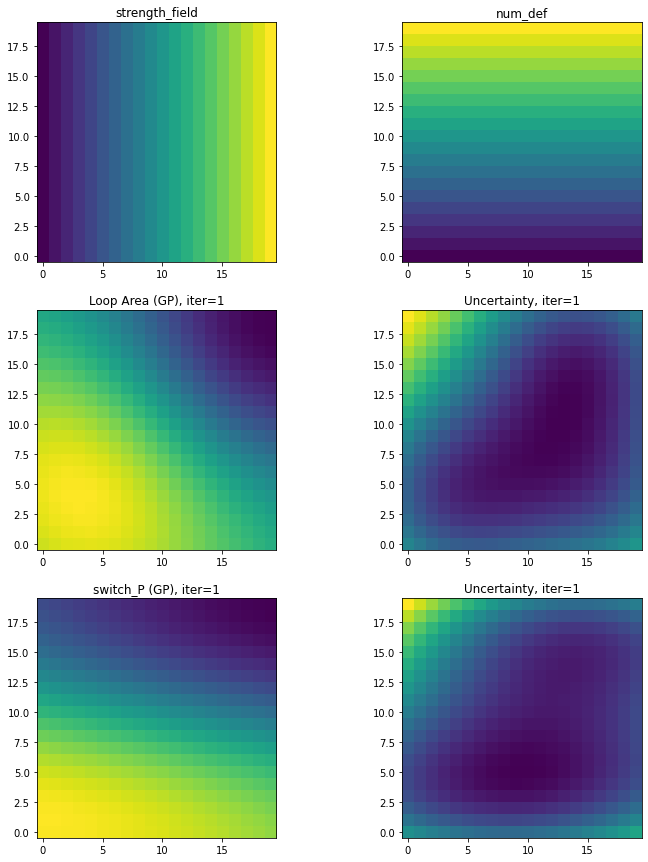

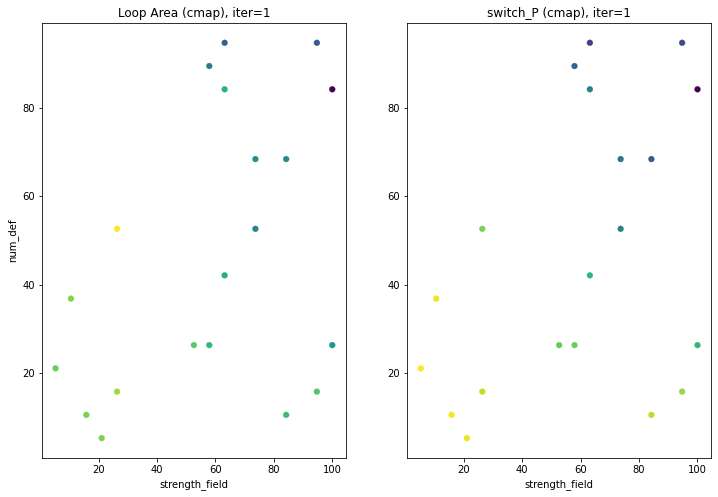

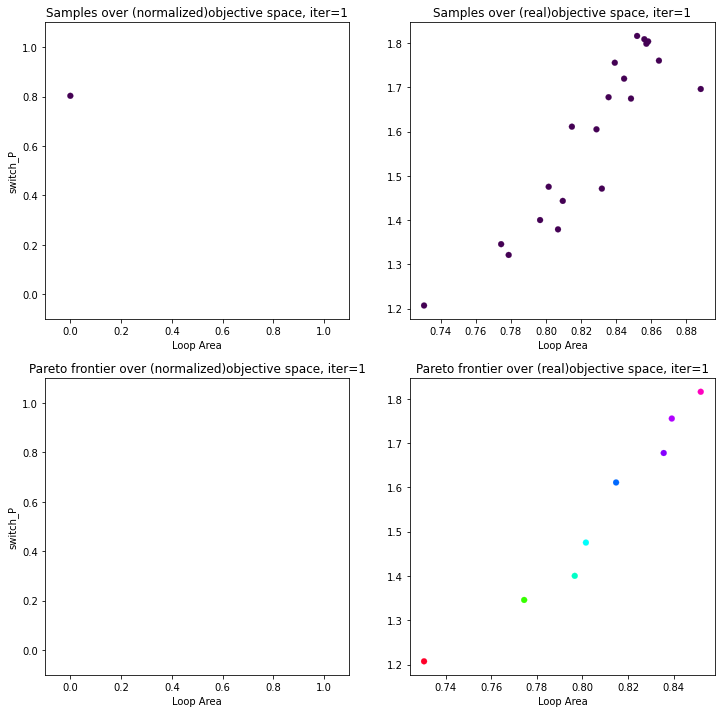

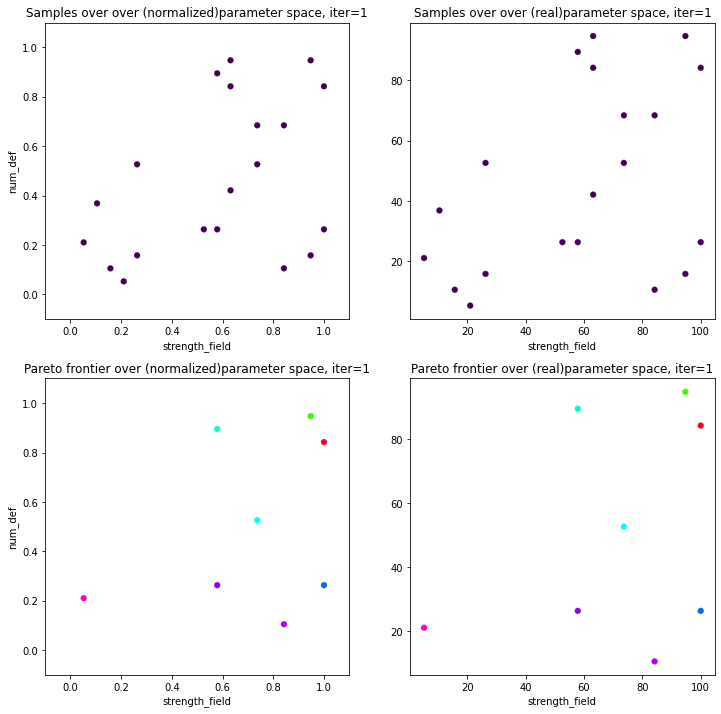

Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #27
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #28
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #29
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


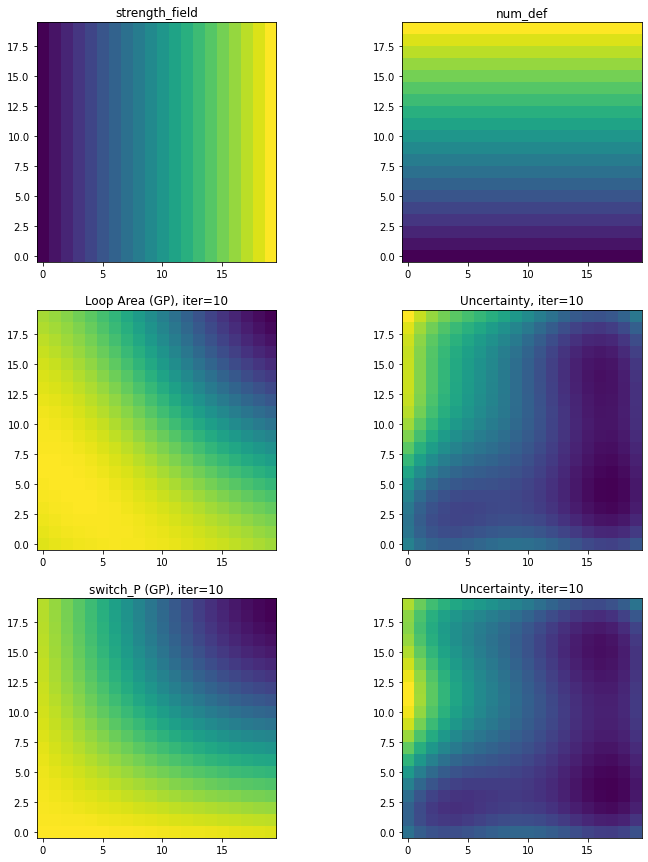

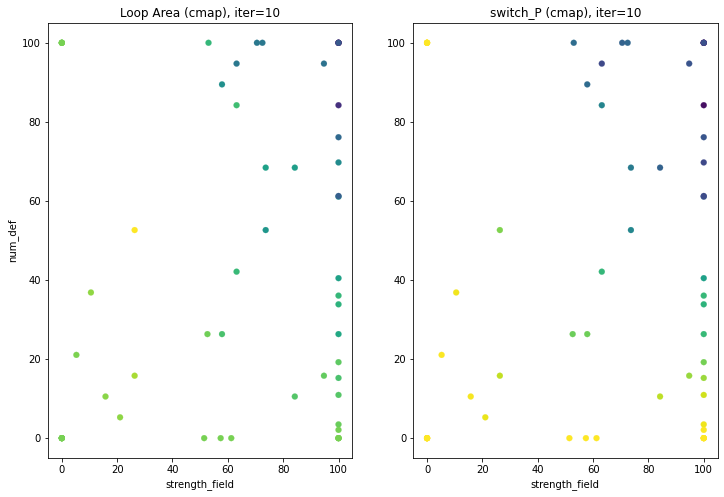

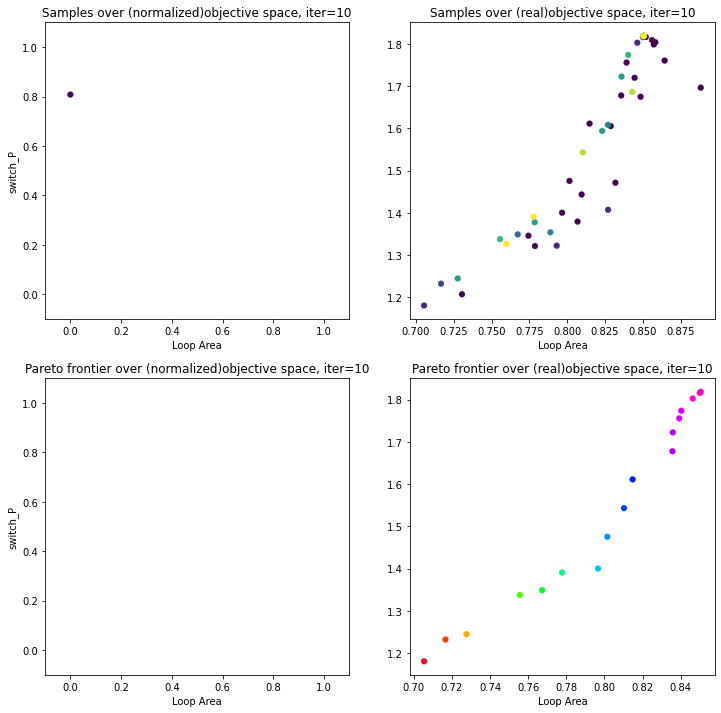

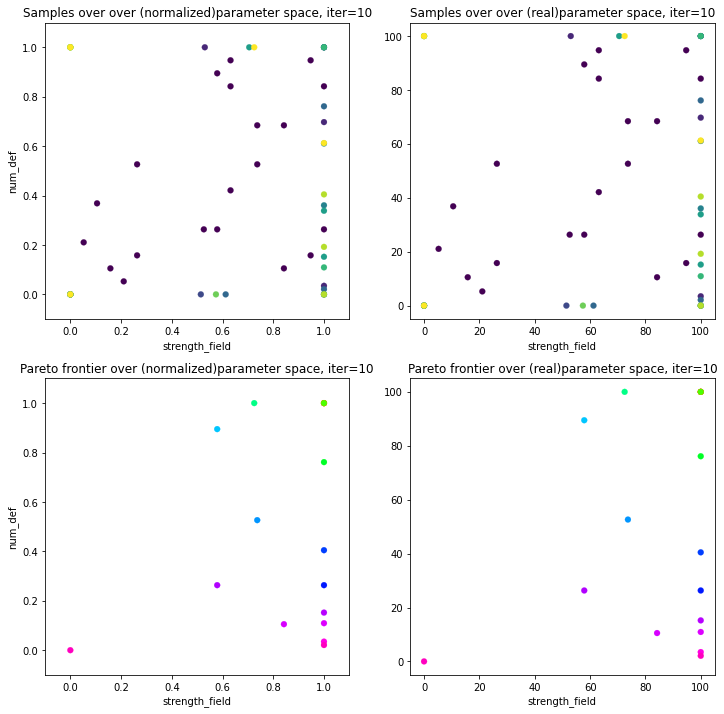

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #36
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #37
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #38
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #39
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


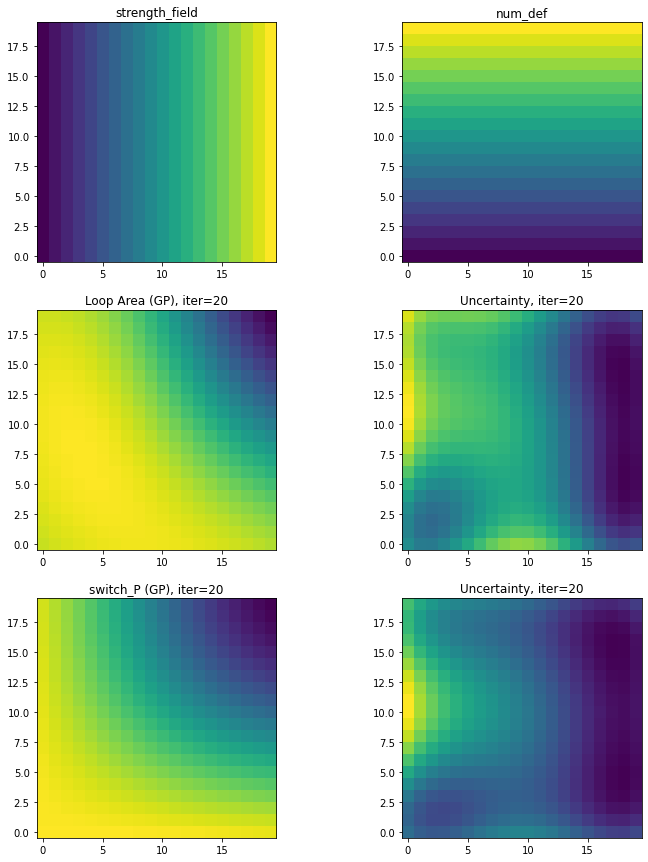

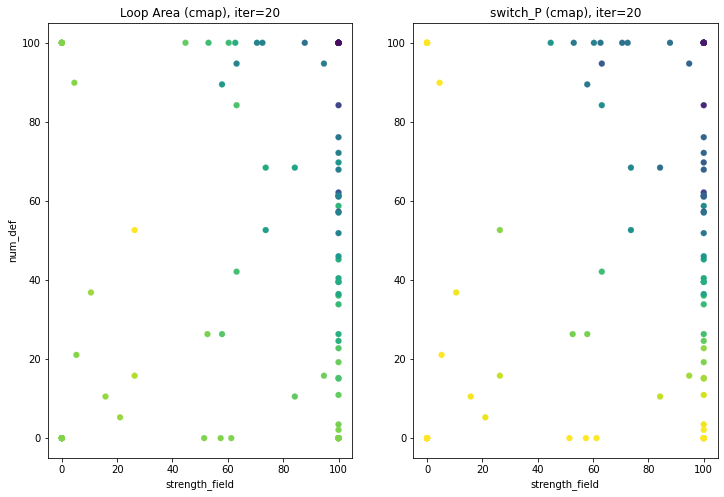

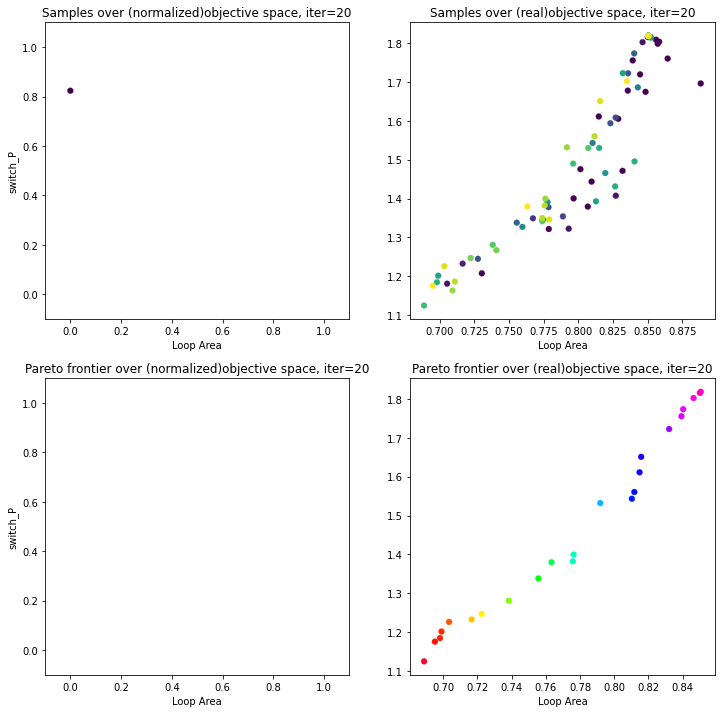

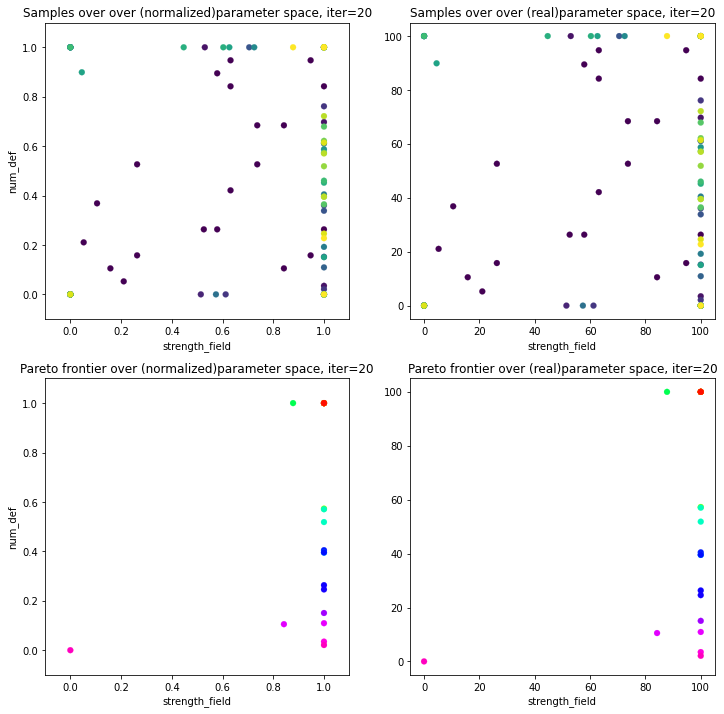

Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #48
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #49
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


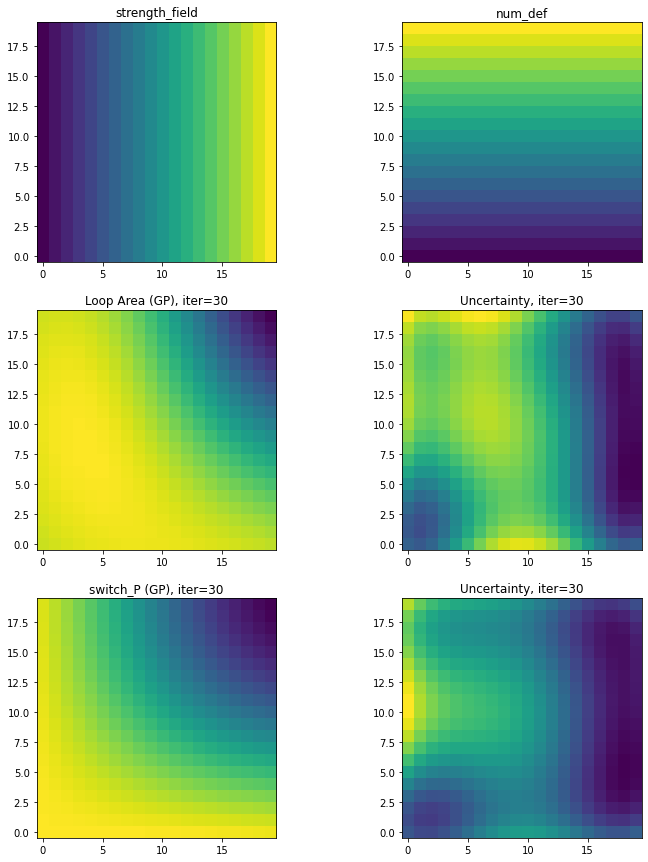

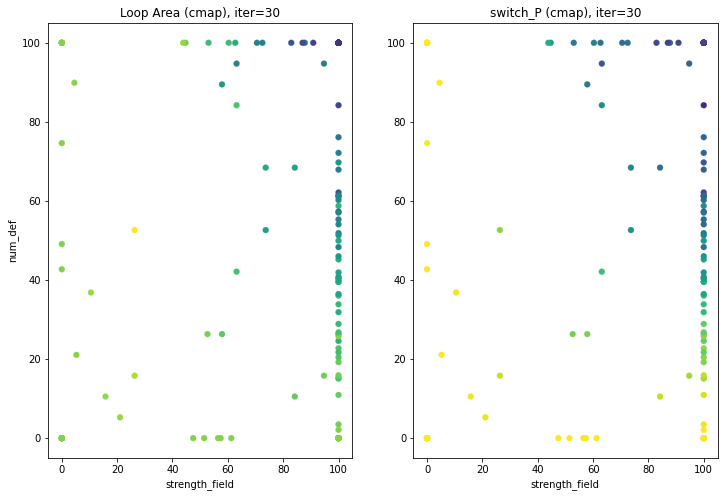

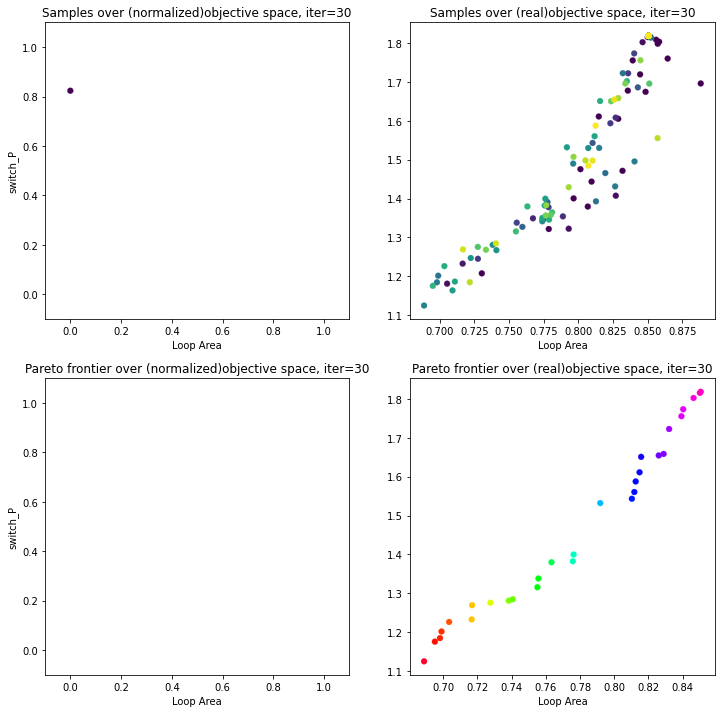

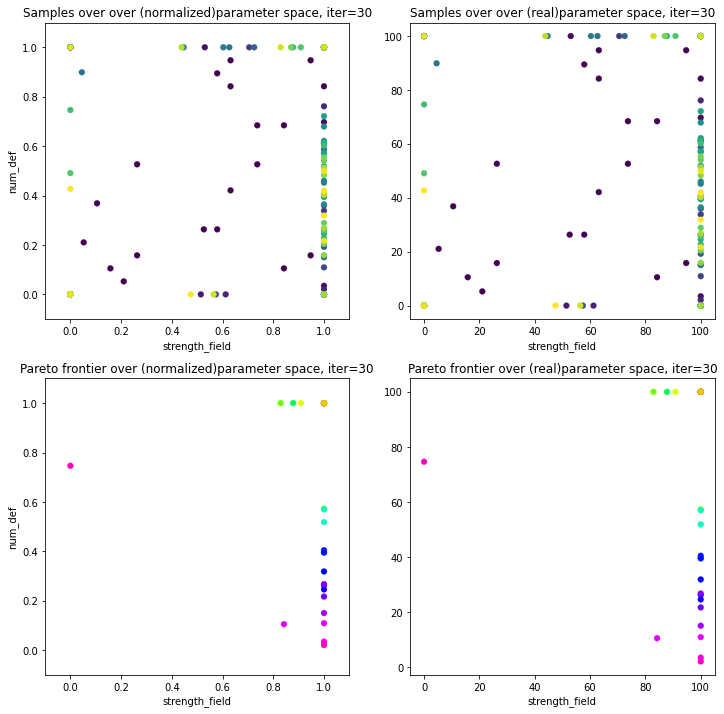

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #51
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #52
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #53
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #54
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #55
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #56
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #57
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #58
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #59
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


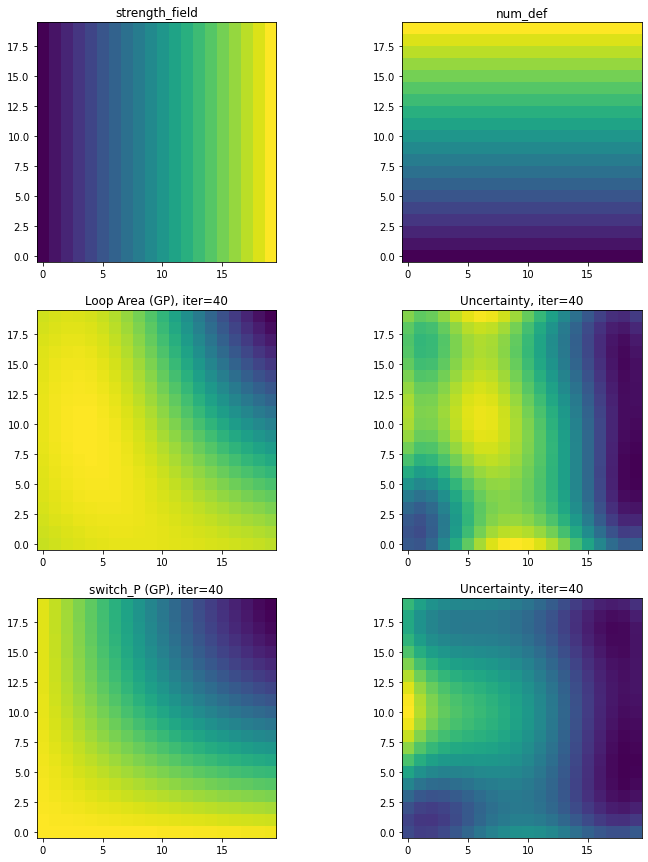

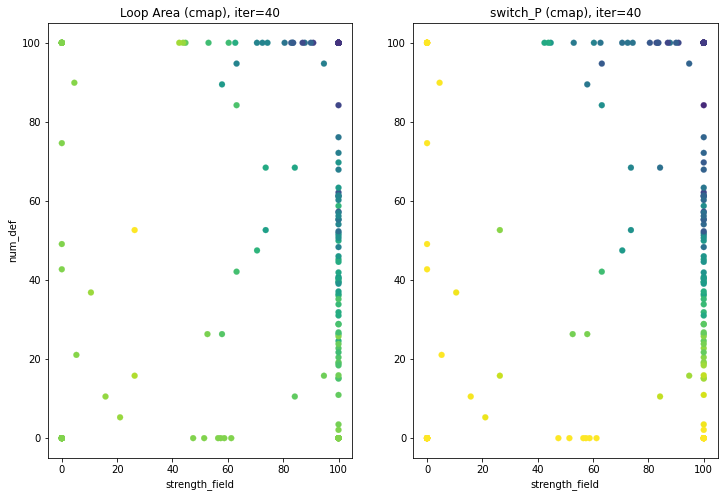

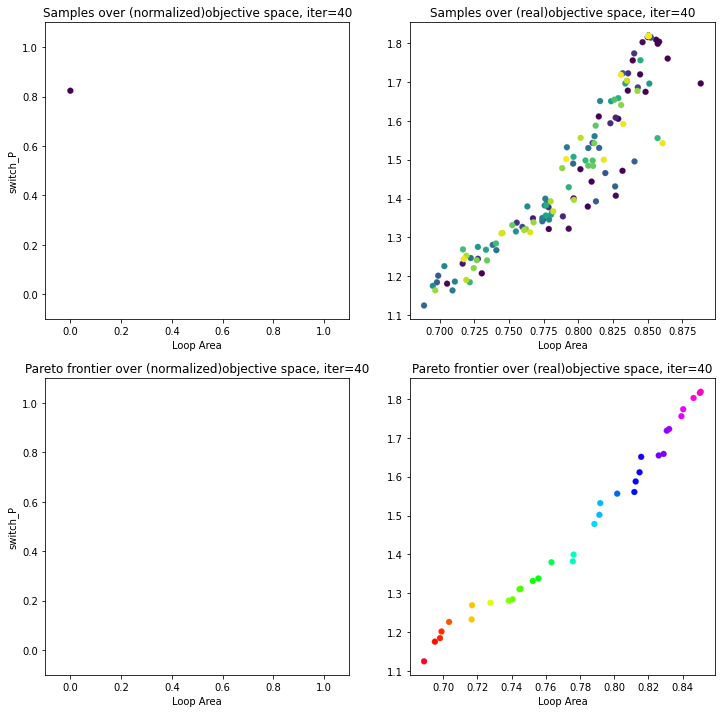

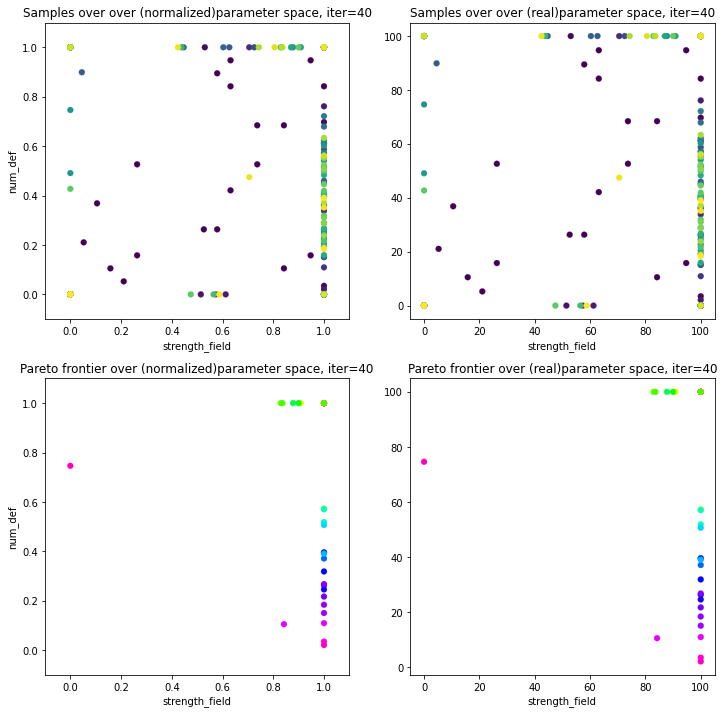

Batch Function eval #60
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #61
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #62
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #63
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #64
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #65
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #66
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #67
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #68
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

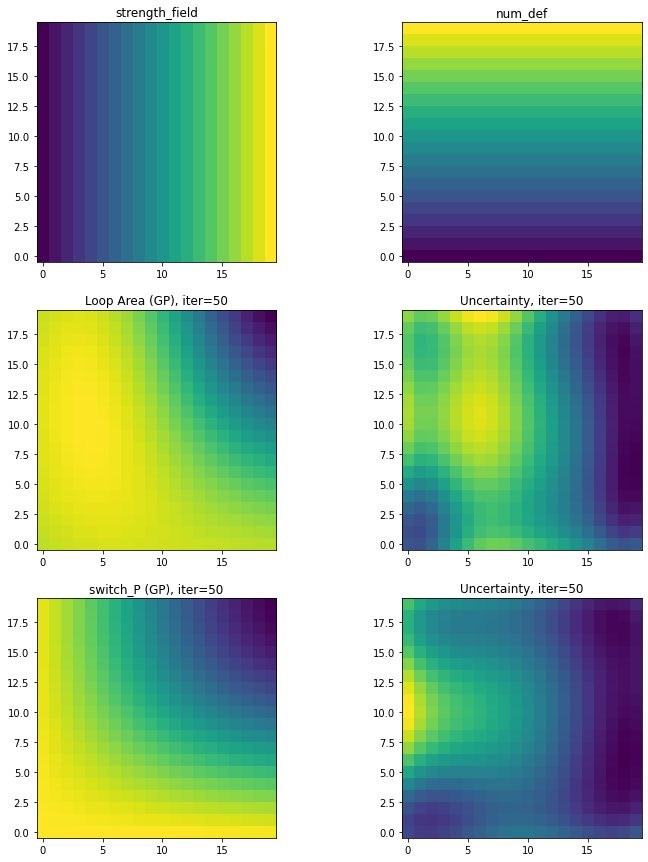

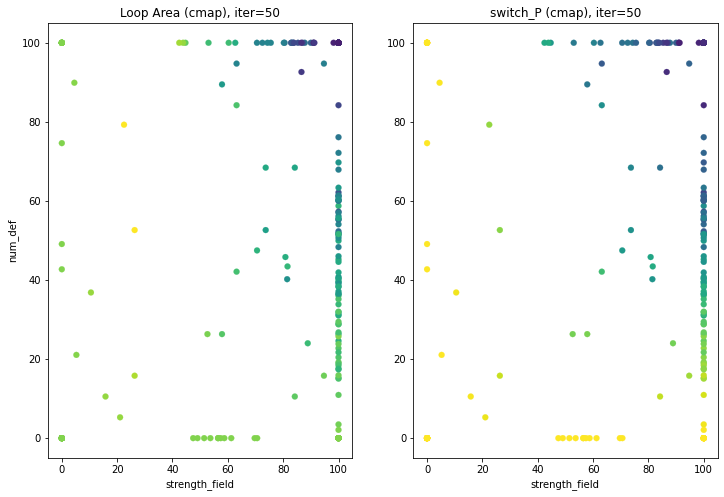

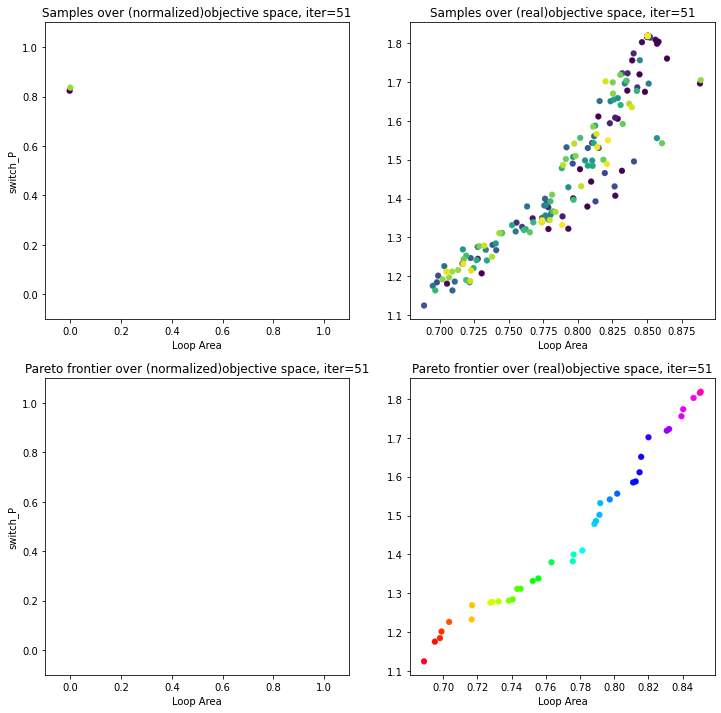

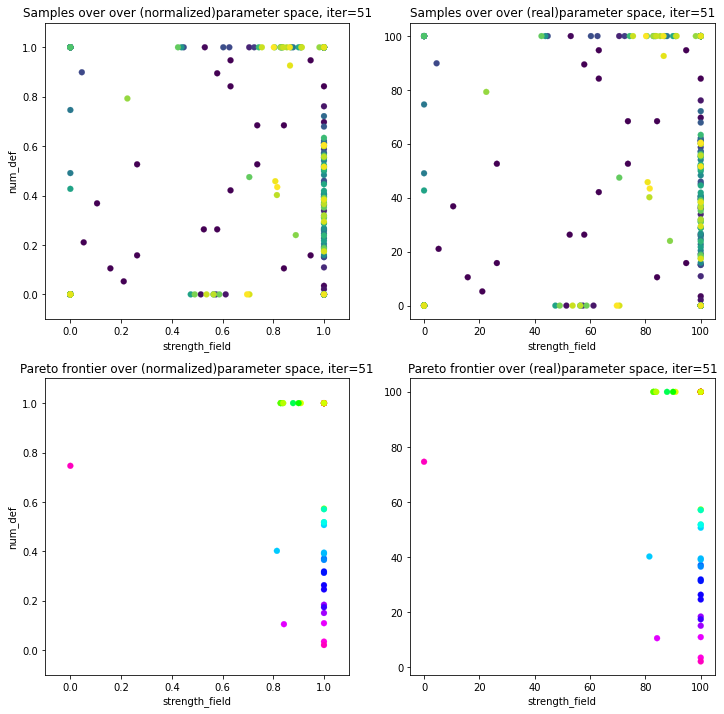

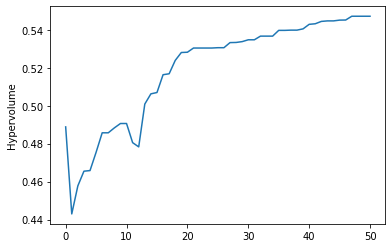

In [11]:
####################### Run BO ##############################

tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4 #For each iteration in BO, how many future samples we select in batch

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParego' -qParEGO
acquisition = 'qParEGO'

#Parameters
param1 = 'strength_field'
param2 = 'num_def'

# Choose any two objectives to do MOO (MOBO)-
# Choose objective 2 either 'switch_P'- swichable polarization or 'target_switchP' - setting a target value for switchable P which the user want to achieve.
obj1 = 'Loop Area'
obj2 = 'switch_P'

# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['min','max']

#Define parameter space based on above choice of params (2D only)
num_rows =20
num = 20  # Starting samples
N=50

num_def = np.linspace(0, 100, num_rows)
test_num_def = np.linspace(0, 100, num_rows)
strength_field = np.linspace(0, 100, num_rows)
test_strength_field = np.linspace(0, 100, num_rows)

X1 = strength_field
test_X1 = test_strength_field
X2 = num_def
test_X2 = test_num_def


#Call function to run MOBO (physics driven)

#input args in serial: X1- grid array of param 1, X2- grid array of param2, test_X1, test_X2- grid numpy arrays for param X1, X2 (for optional posterior calculations); num_rows, N, BATCH_SIZE- explained in text sections; 
#param1, param2 - string names of parameter 1, 2; obj1, obj2 - string names of objective 1, 2; acquisition - string name as provided in text section for user choice of acquistion function method;
# problem - string array as provided in text section for user choice of maxmimization or minimization of objectives.
MOBO_ferroSim(X1, X2, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem)


<h1> Analysis 1b

Using **qEHVI** acquistion function

Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO- acq func: qEHVI


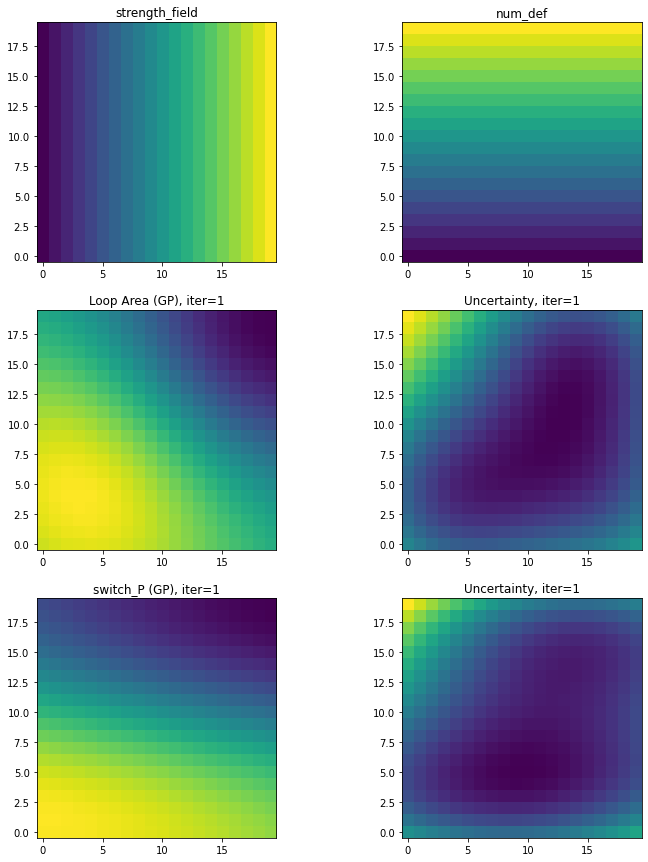

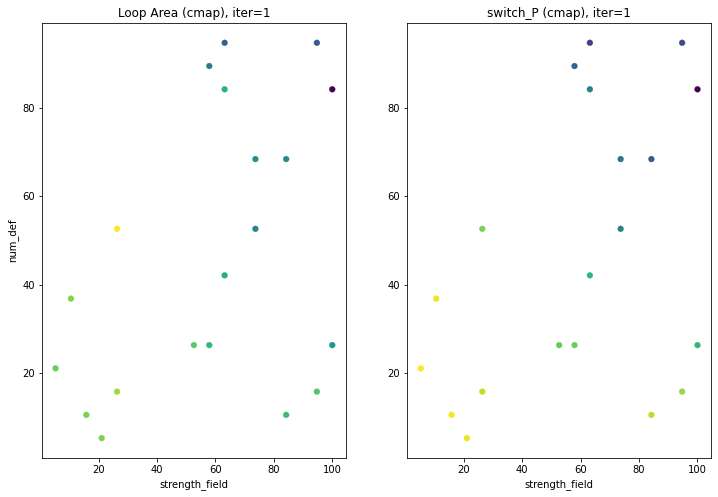

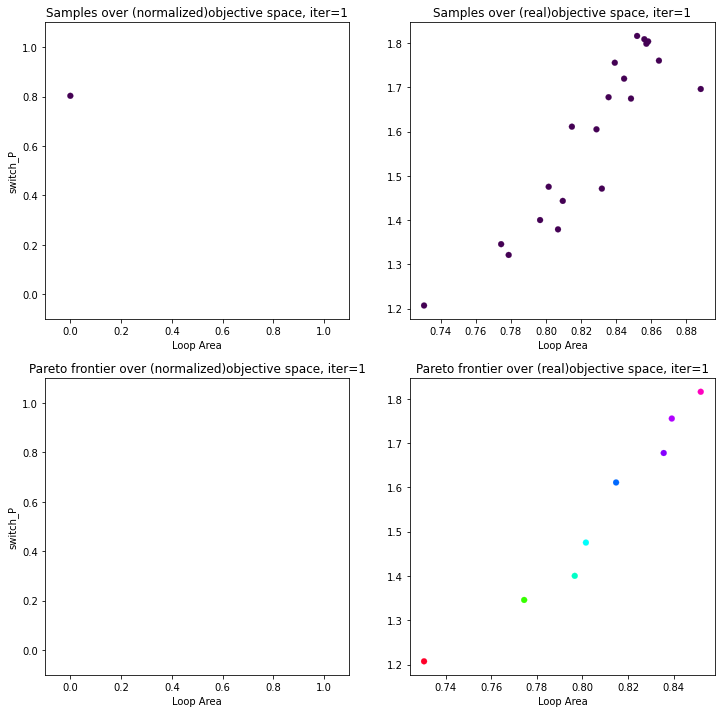

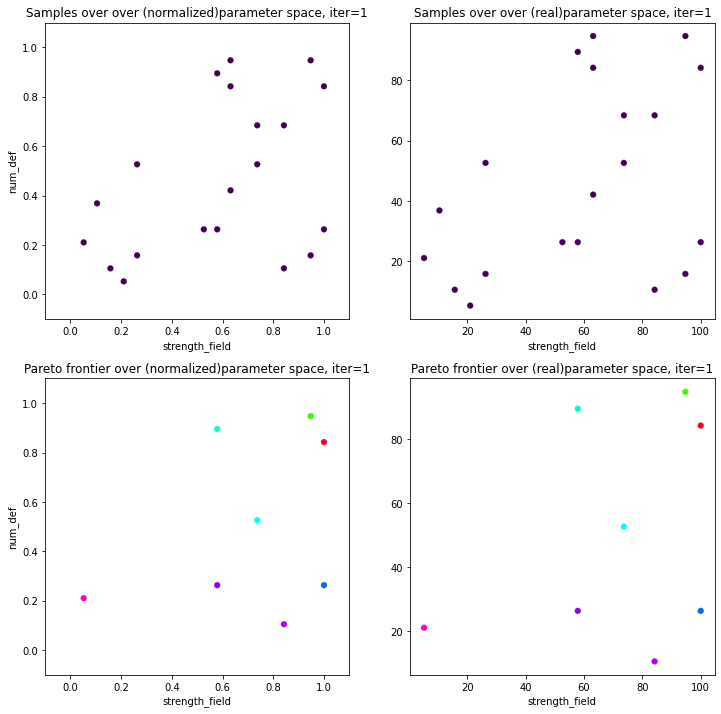

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #27
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #28
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #29
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


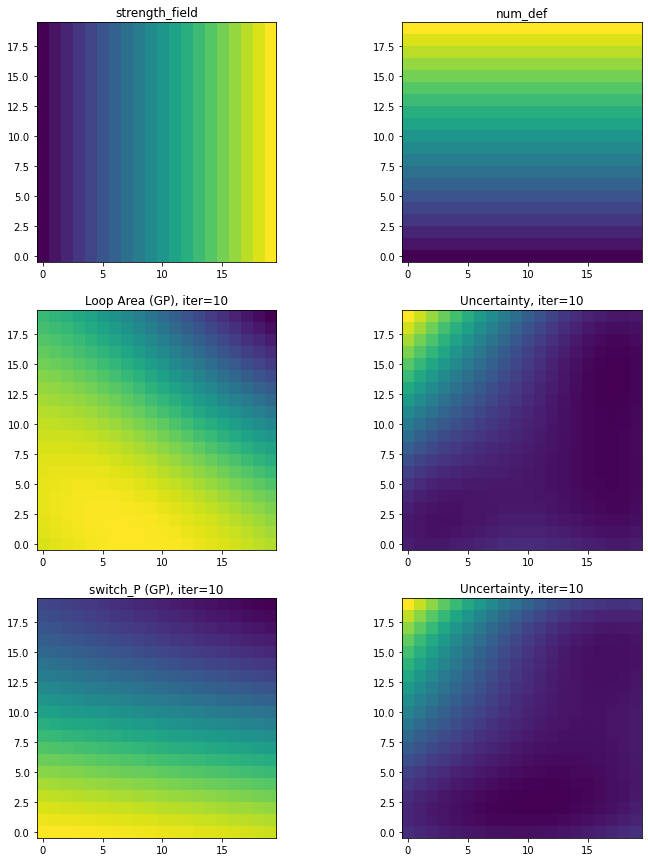

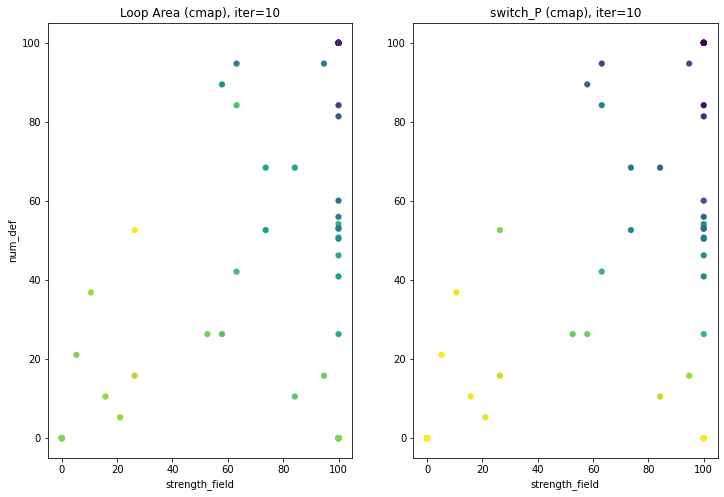

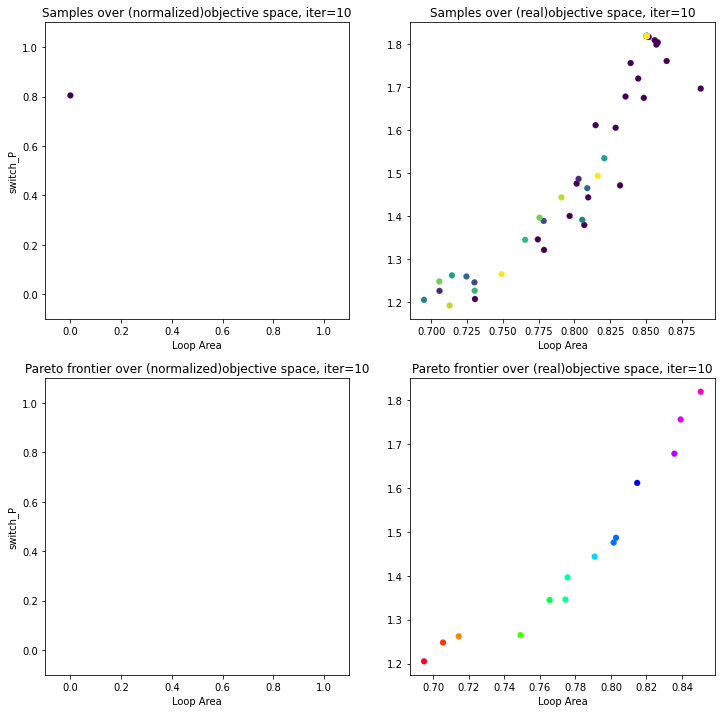

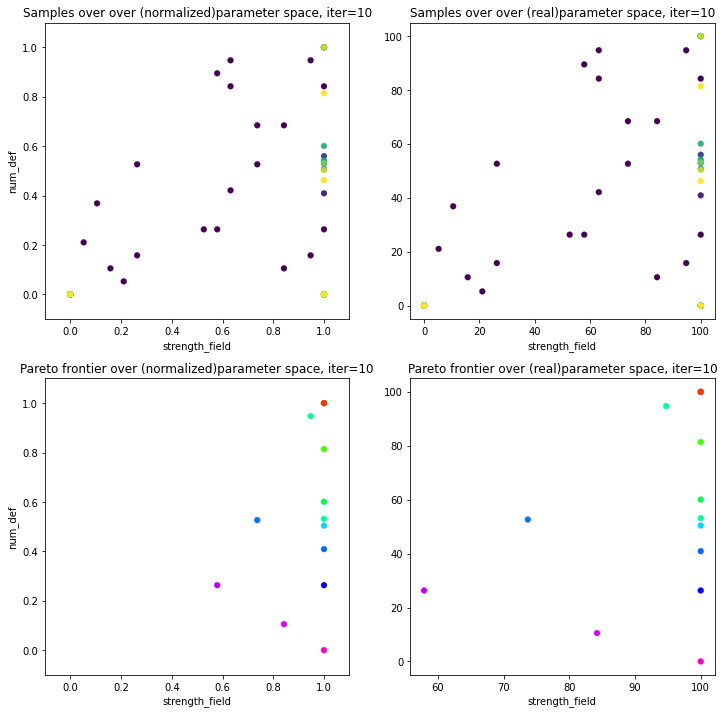

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #36
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #37
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #38
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #39
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


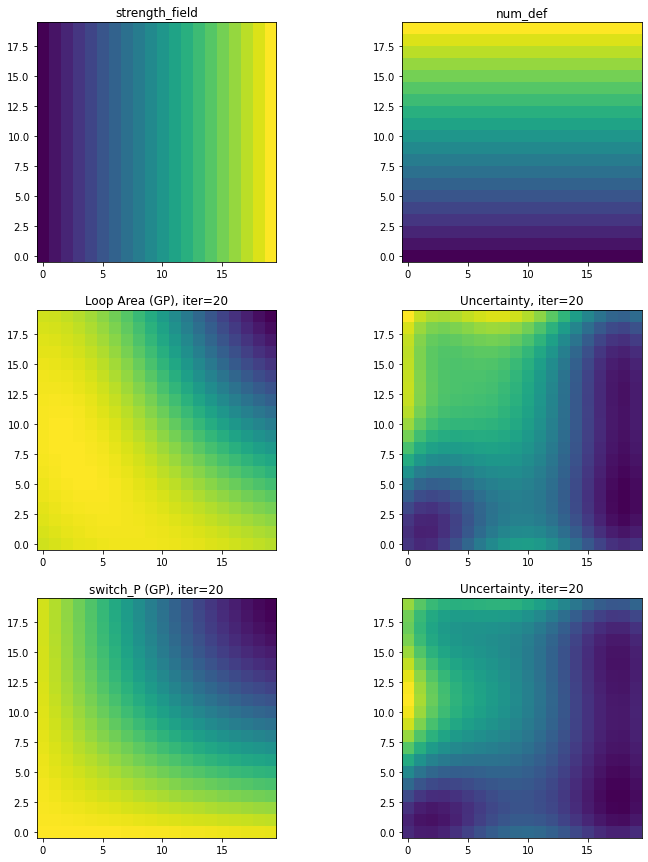

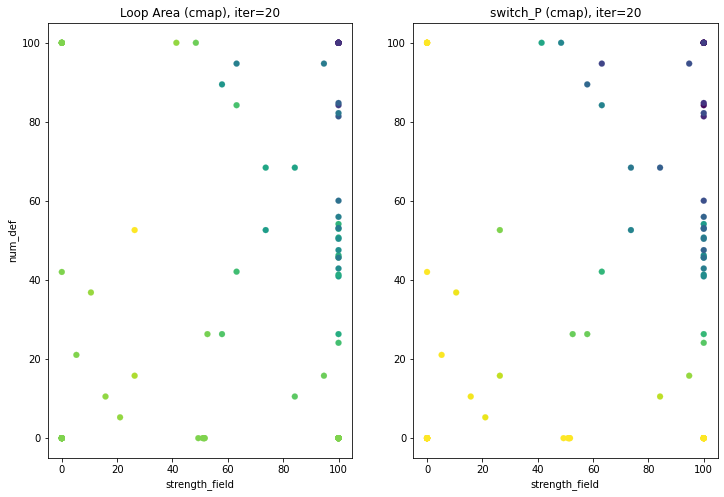

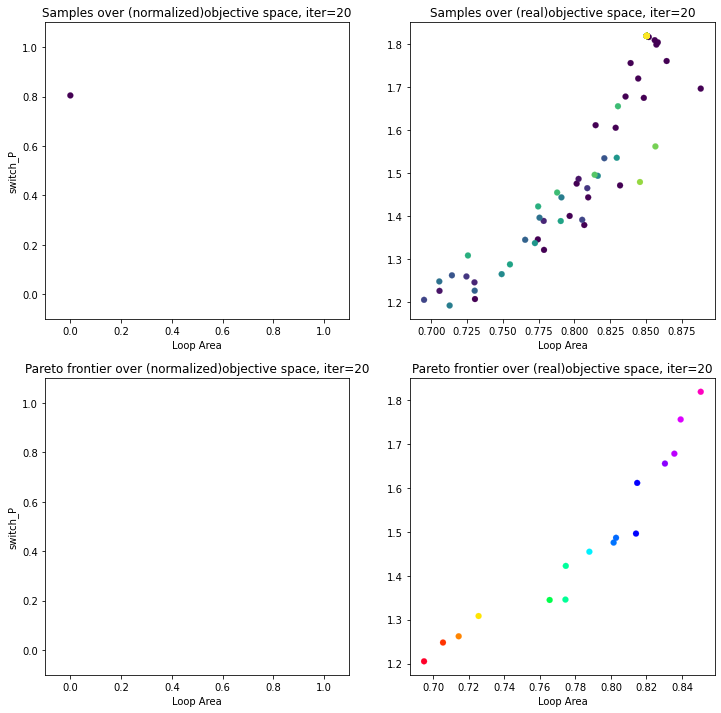

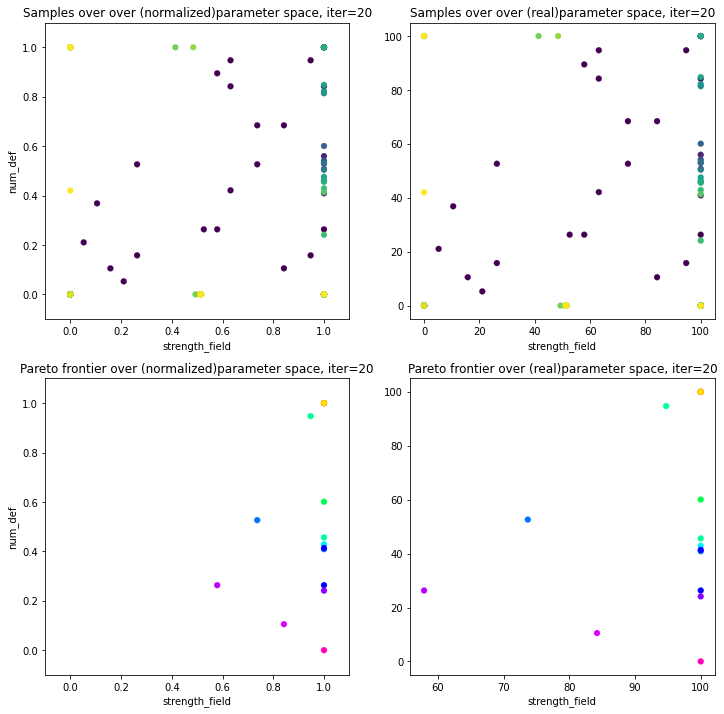

Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #46
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #47
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #48
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #49
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


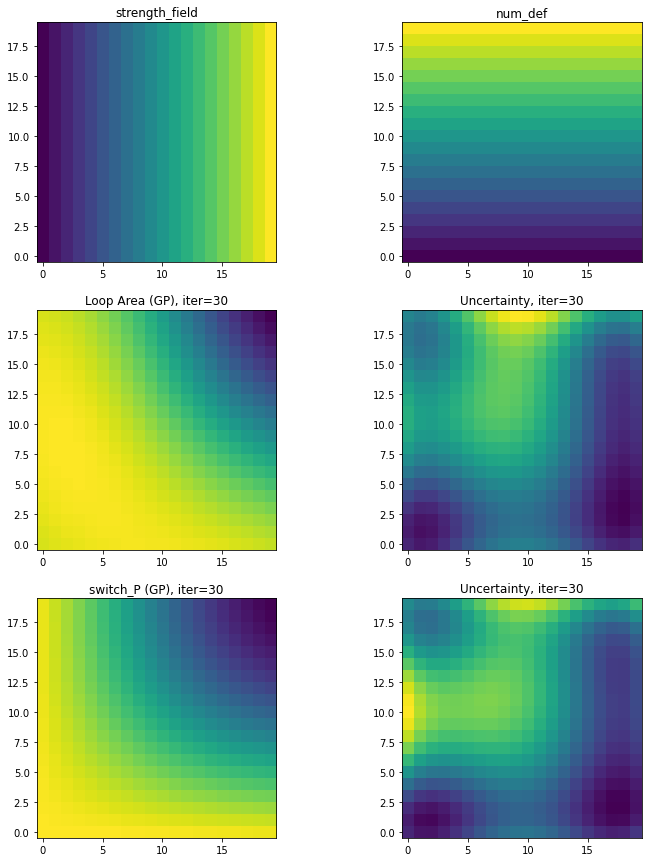

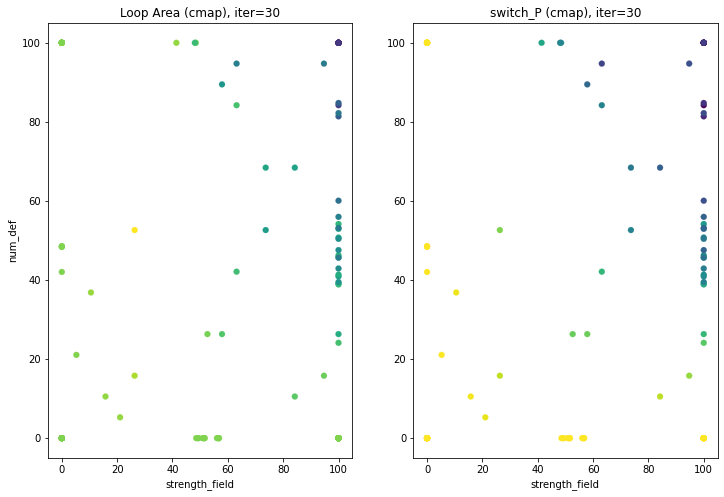

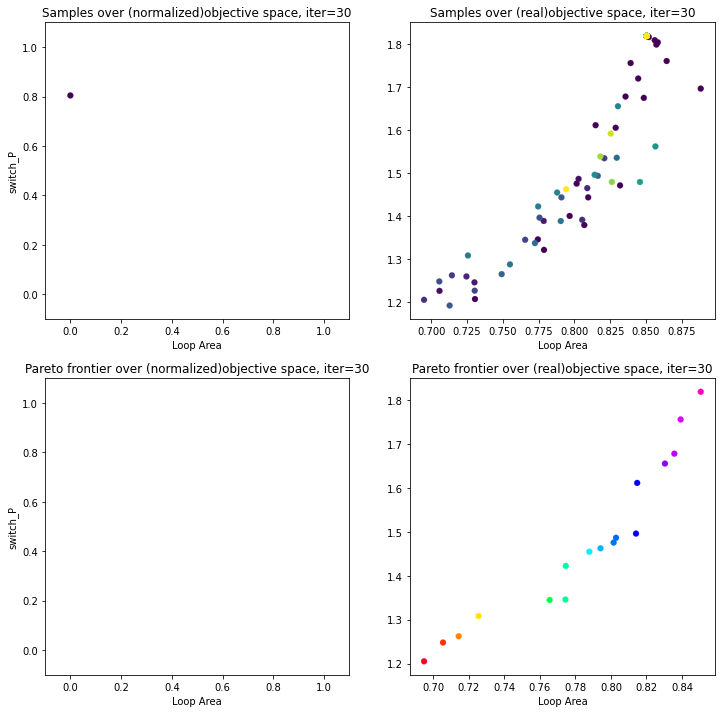

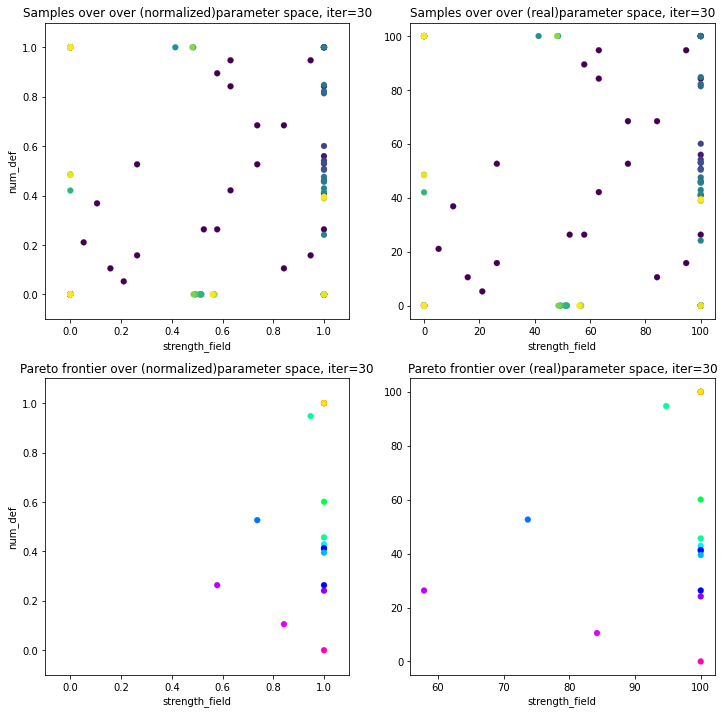

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #51
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #52
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #53
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #54
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #55
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #56
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #57
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #58
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #59
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


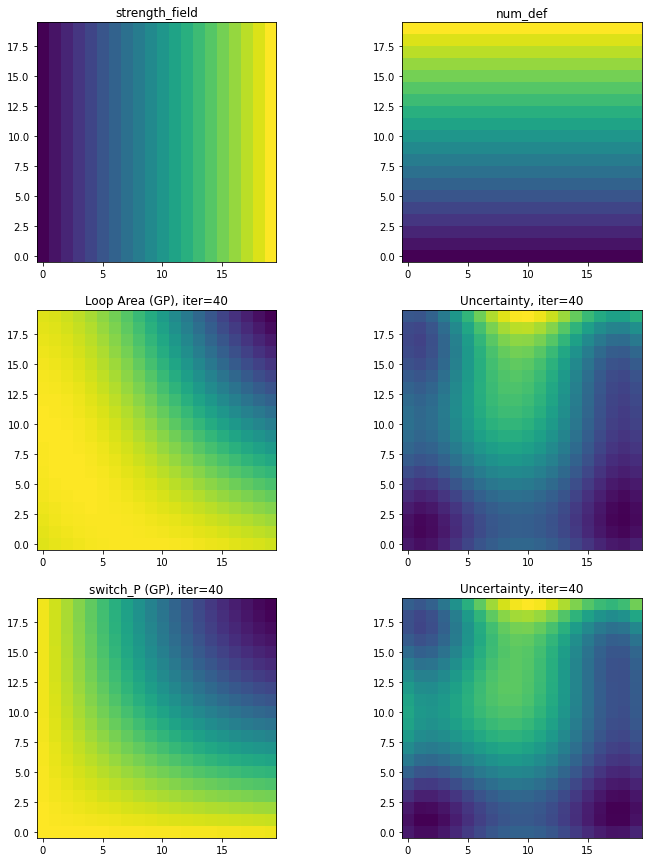

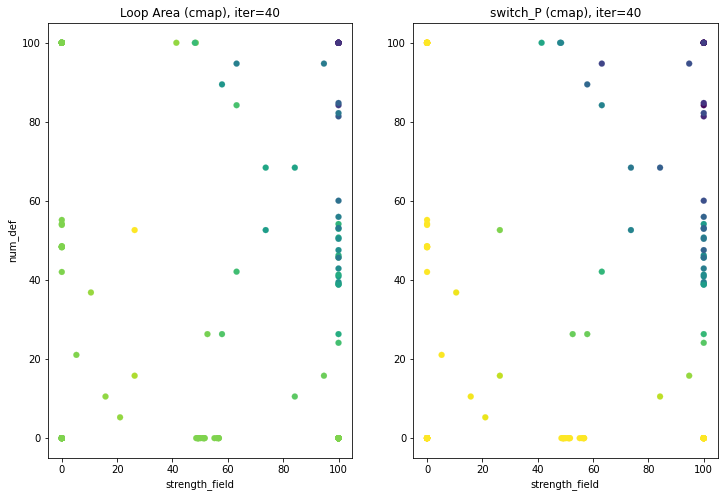

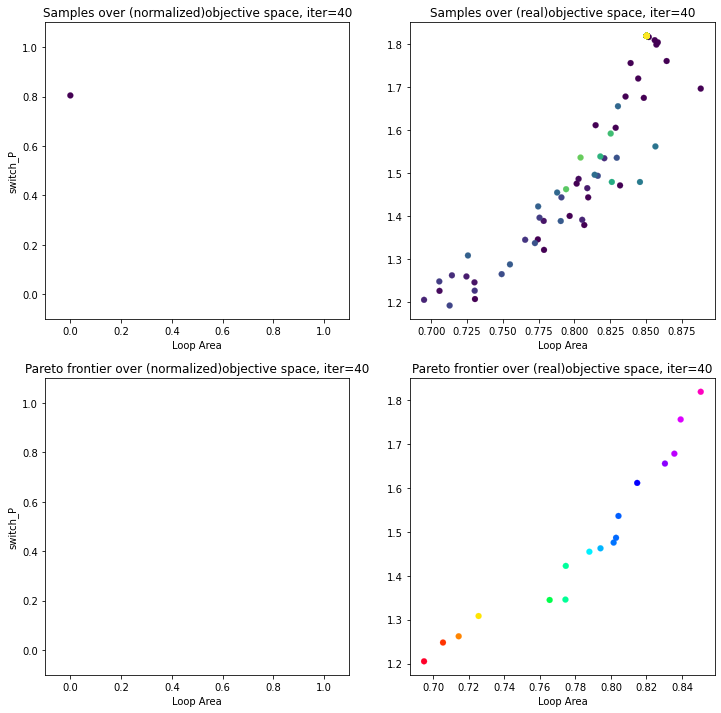

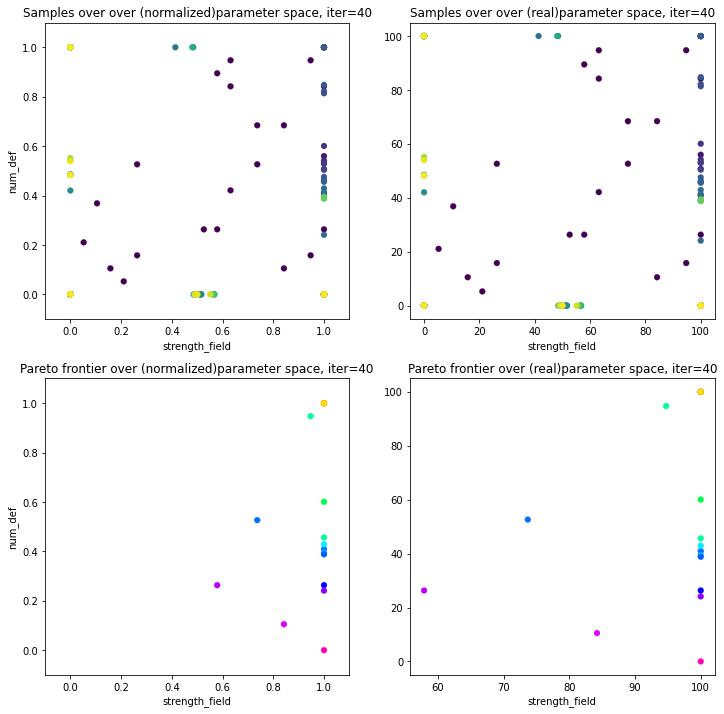

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #60
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #61
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #62
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #63
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #64
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #65
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #66
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #67
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #68
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #69
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #70
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Max. sampling reached, model stopped


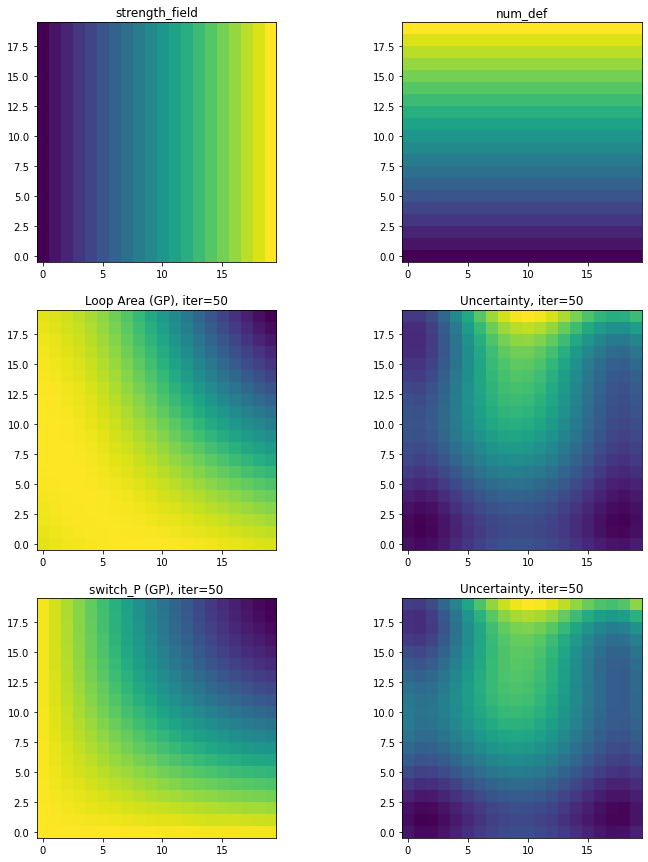

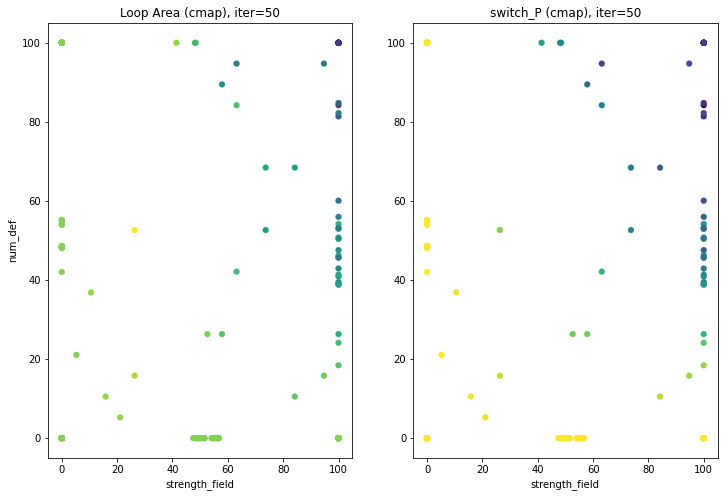

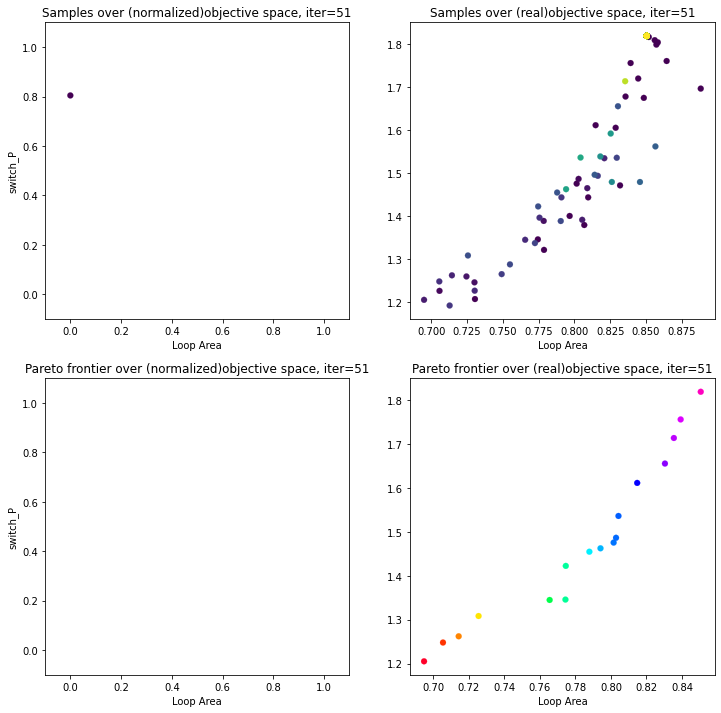

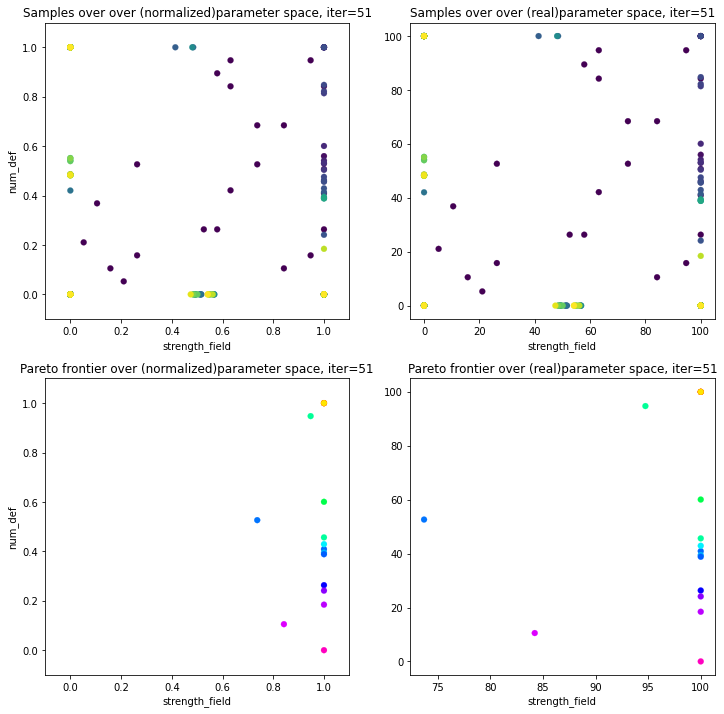

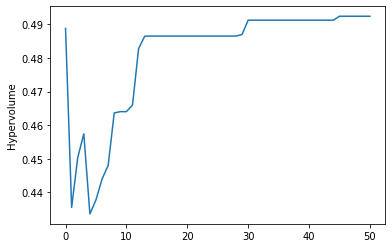

In [12]:
####################### Run BO ##############################

tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4 #For each iteration in BO, how many future samples we select in batch

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParego' -qParEGO
acquisition = 'qEHVI'

#Parameters
param1 = 'strength_field'
param2 = 'num_def'

# Choose any two objectives to do MOO (MOBO)-
# Choose objective 2 either 'switch_P'- swichable polarization or 'target_switchP' - setting a target value for switchable P which the user want to achieve.
obj1 = 'Loop Area'
obj2 = 'switch_P'

# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['min','max']

#Define parameter space based on above choice of params (2D only)
num_rows =20
num = 20  # Starting samples
N=50

num_def = np.linspace(0, 100, num_rows)
test_num_def = np.linspace(0, 100, num_rows)
strength_field = np.linspace(0, 100, num_rows)
test_strength_field = np.linspace(0, 100, num_rows)

X1 = strength_field
test_X1 = test_strength_field
X2 = num_def
test_X2 = test_num_def


#Call function to run MOBO (physics driven)

#input args in serial: X1- grid array of param 1, X2- grid array of param2, test_X1, test_X2- grid numpy arrays for param X1, X2 (for optional posterior calculations); num_rows, N, BATCH_SIZE- explained in text sections; 
#param1, param2 - string names of parameter 1, 2; obj1, obj2 - string names of objective 1, 2; acquisition - string name as provided in text section for user choice of acquistion function method;
# problem - string array as provided in text section for user choice of maxmimization or minimization of objectives.
MOBO_ferroSim(X1, X2, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem)


Lets see the ground truth of 1 with low-sampling exhaustive search



Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Function eval #21
Function eval #22
Function eval #23
Function eval #24
Function eval #25
Function eval #26
Function eval #27
Function eval #28
Function eval #29
Function eval #30
Function eval #31
Function eval #32
Function eval #33
Function eval #34
Function eval #35
Function eval #36
Function eval #37
Function eval #38
Function eval #39
Function eval #40
Function eval #41
Function eval #42
Function eval #43
Function eval #44
Function eval #45
Function eval #46
Function eval #47
Function eval #48
Function eval #49
Function eval #50
Function eval #51
Function eval #52
Function eval #53
Function eval #54
Function eval #55
Function eval #56
F

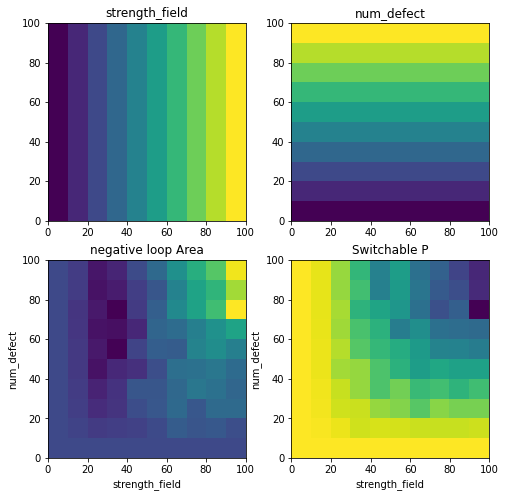

In [10]:
num_rows =10
X1 = np.linspace(0, 100, num_rows)
X2 = np.linspace(0, 100, num_rows)
m=0
X1, X2 = np.meshgrid(X1, X2)
y_true = np.zeros((num_rows, num_rows, 2))
for t1, (x1, x2) in enumerate(zip(X1, X2)):
    for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
        print("Function eval #" + str(m + 1))
        f1, f2 = cal_objective1(10, xx1, int(xx2), rTip=3)
        y_true[t1, t2, 0]= -f1
        y_true[t1, t2, 1]= f2
        m=m+1

_, ax1 = plt.subplots(2, 2, figsize=(8, 8))
ax1[0, 0].imshow(X1, origin='lower', cmap='viridis', extent=[X1.min(), X1.max(), X1.min(), X1.max()])
ax1[0, 1].imshow(X2, origin='lower', cmap='viridis', extent=[X2.min(), X2.max(), X2.min(), X2.max()])
ax1[1, 0].imshow(y_true[:, :, 0], origin='lower', cmap='viridis', extent=[X1.min(), X1.max(), X2.min(), X2.max()])
ax1[1, 1].imshow(y_true[:, :, 1], origin='lower', cmap='viridis', extent=[X1.min(), X1.max(), X2.min(), X2.max()])
ax1[1, 0].set_xlabel("strength_field")
ax1[1, 0].set_ylabel("num_defect")
ax1[1, 1].set_xlabel("strength_field")
ax1[1, 1].set_ylabel("num_defect")
ax1[0, 0].set_title("strength_field")
ax1[0, 1].set_title("num_defect")
ax1[1, 0].set_title("negative loop Area")
ax1[1, 1].set_title("Switchable P")
plt.show()

<h1>Analysis 2a

num_rows =20, num = 20, N= 50

Max func evaluation- 50 (max iter)x 4(batch_size) + 20(starting samples)

$defect = [0, 100]; fStrength =[0, 100]$

**Minimize Loop Area and Maximize User Set target of a Swichable Polarization** 

$P_0 = 1.50$, $\delta_P =.075$

acquistion function - **qParEGO**


Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO- acq func: qParEGO


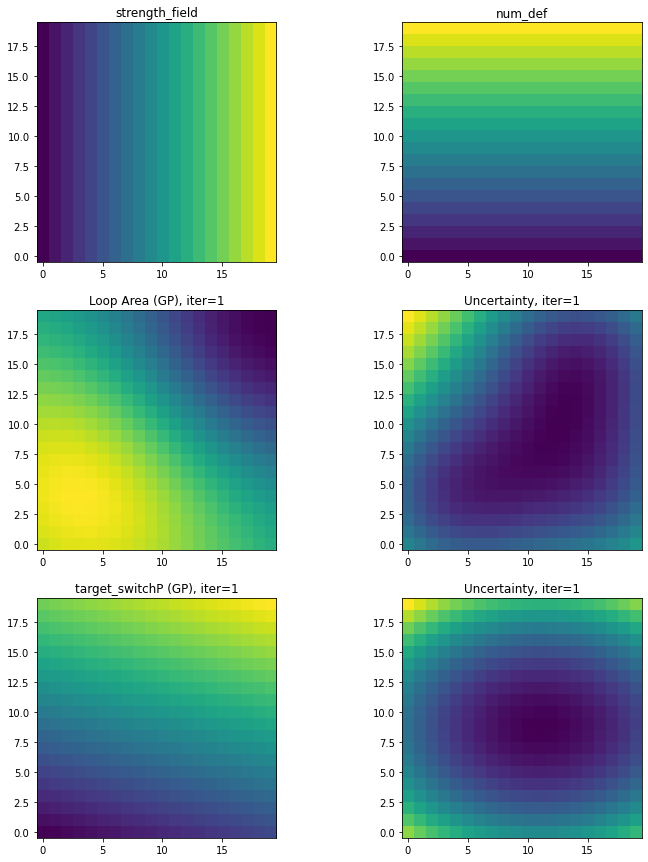

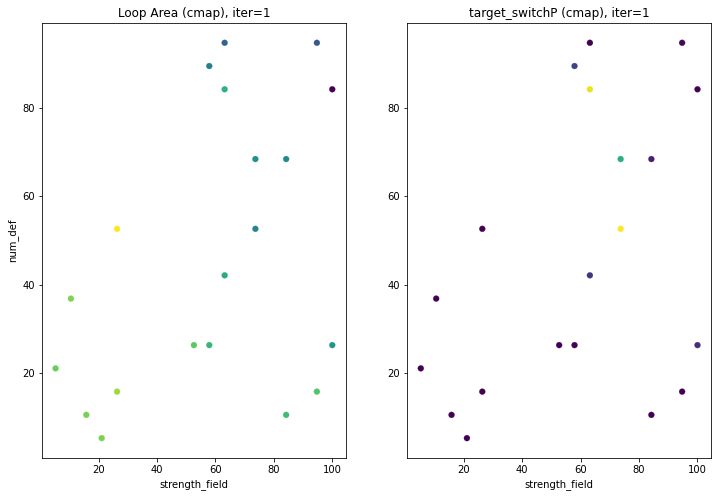

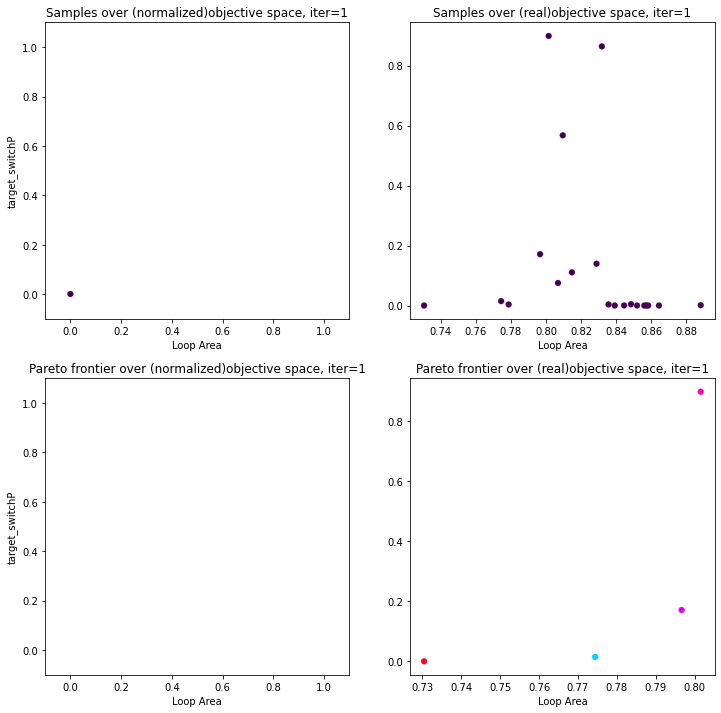

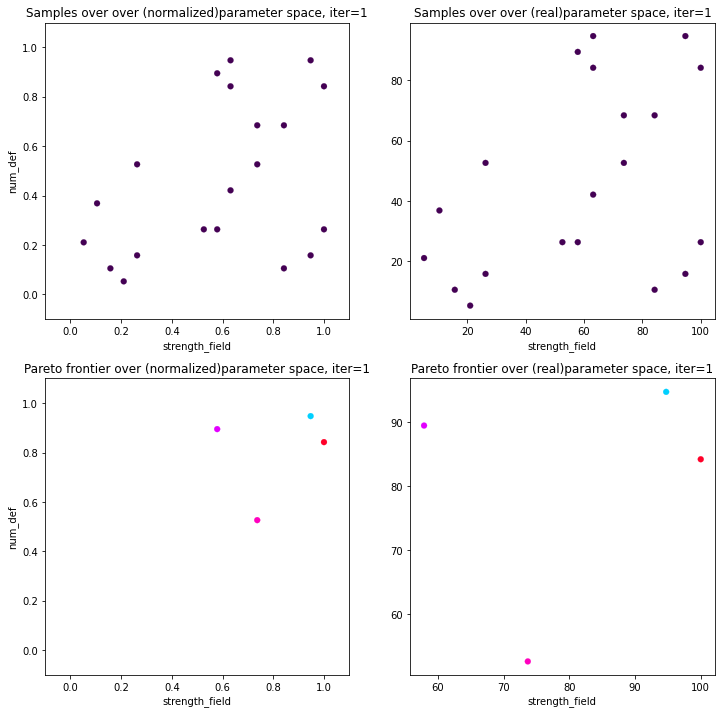

Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

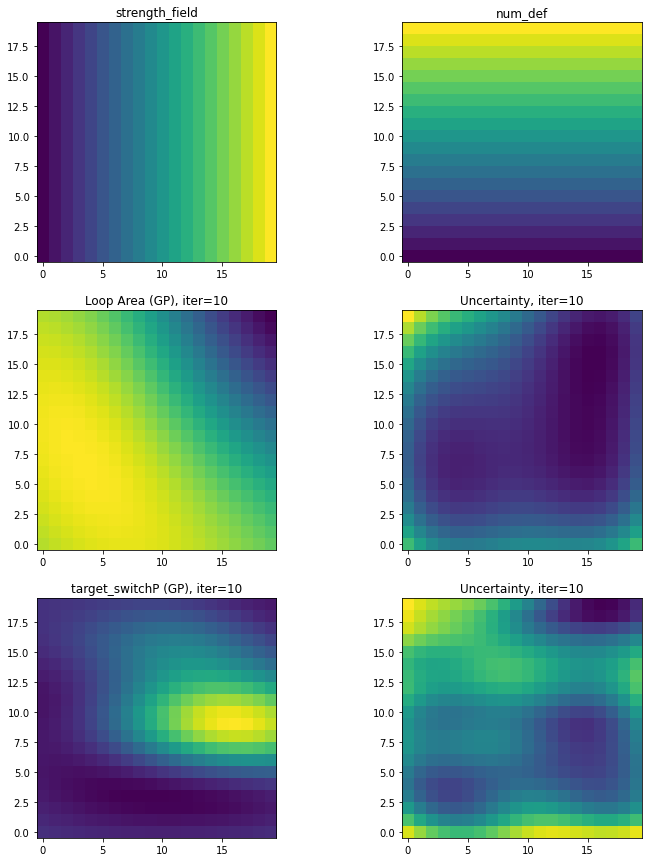

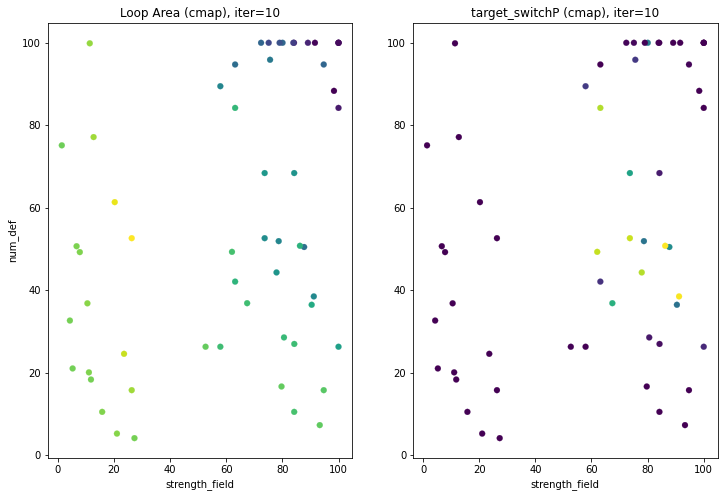

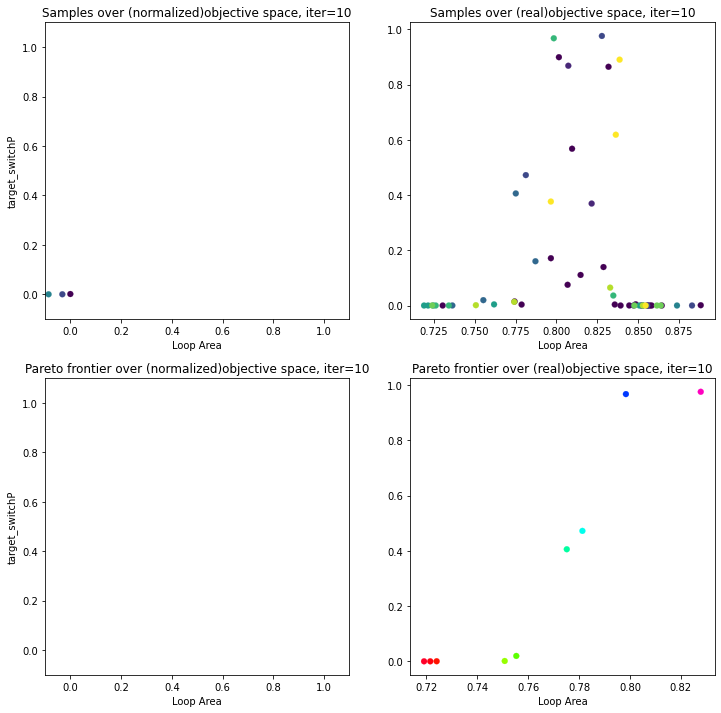

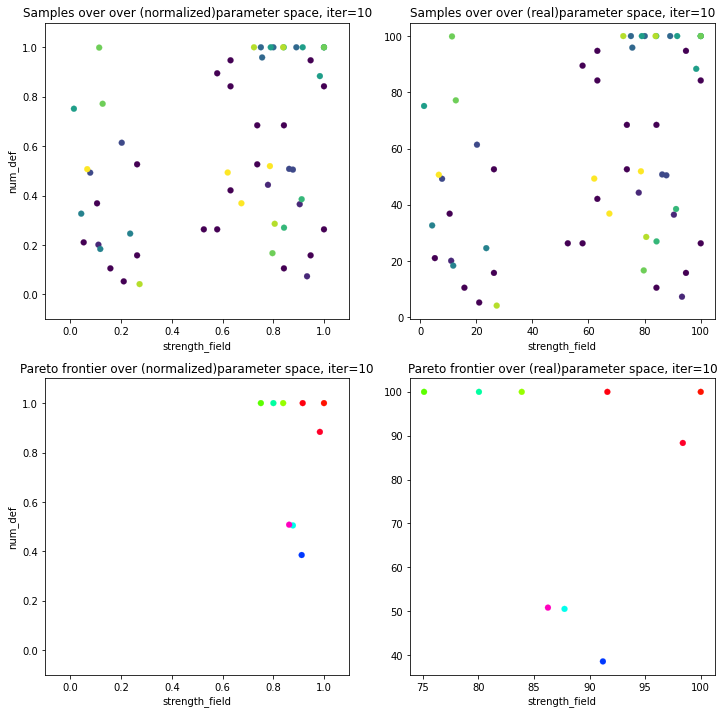

Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #36
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

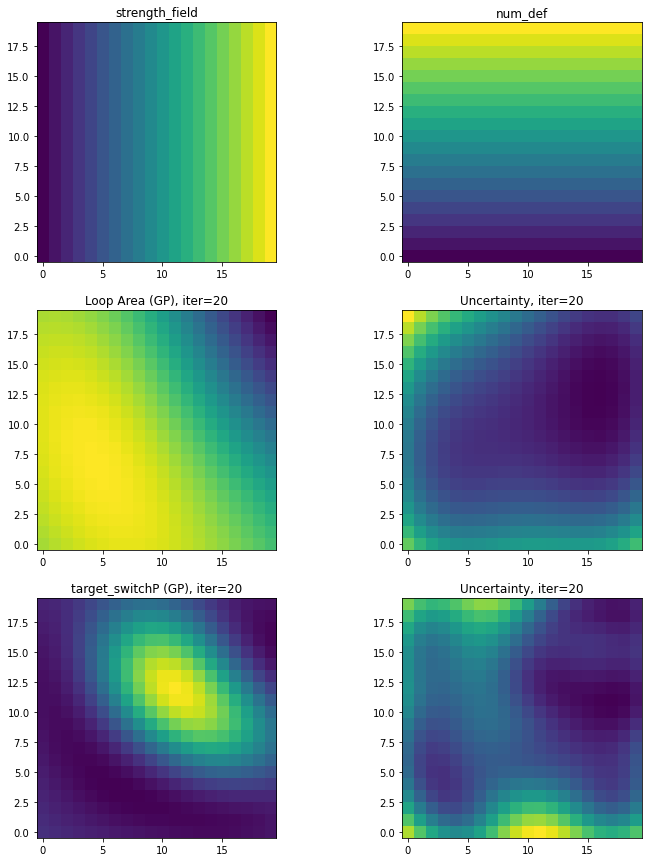

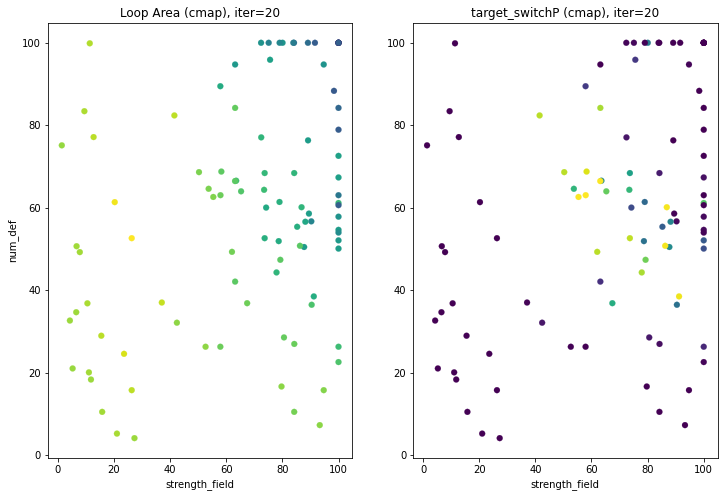

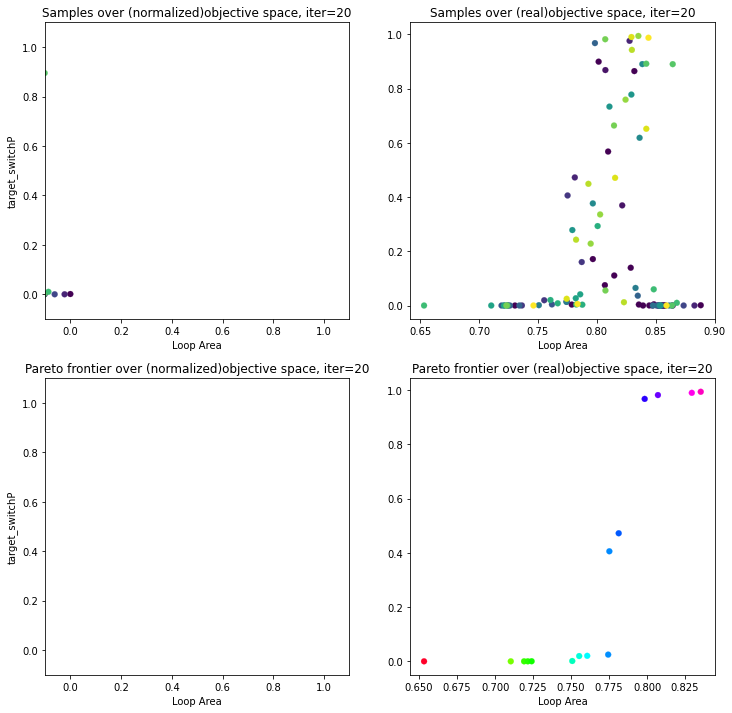

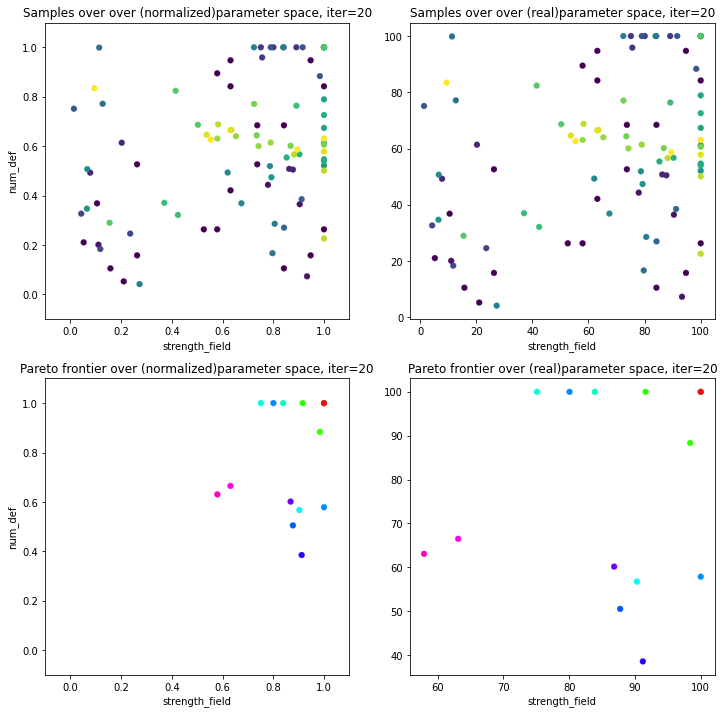

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

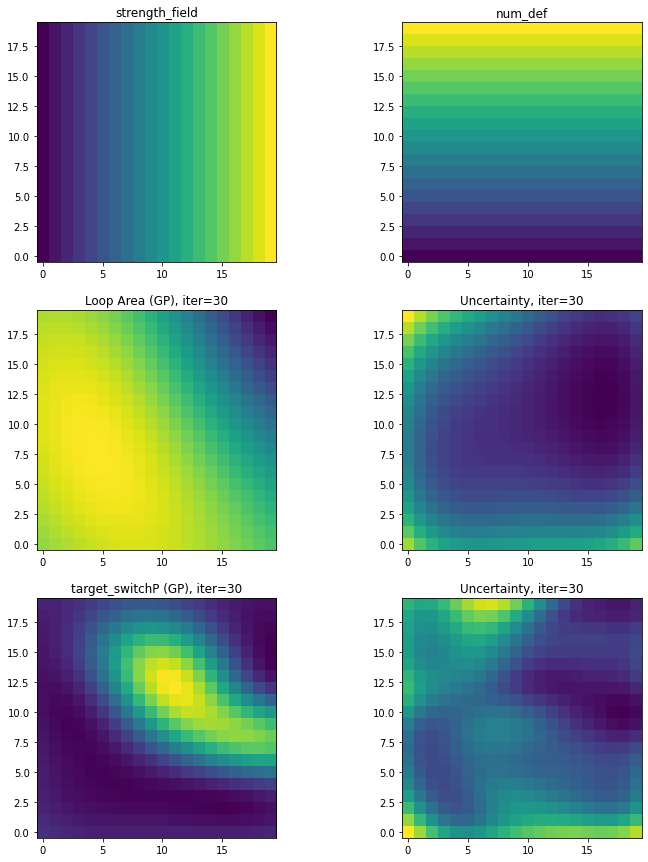

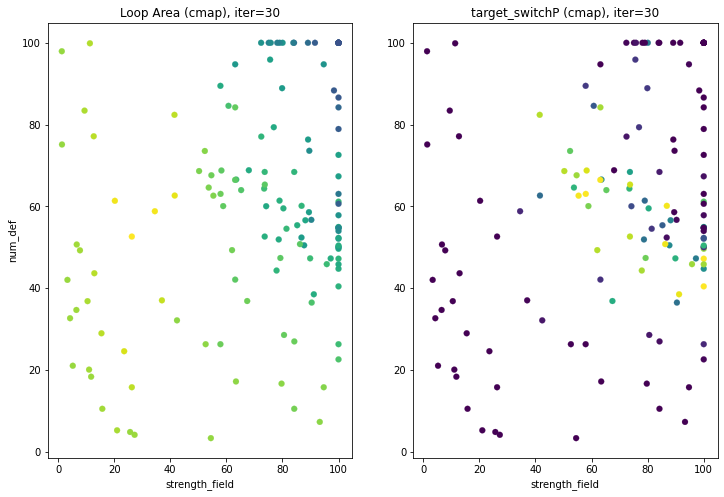

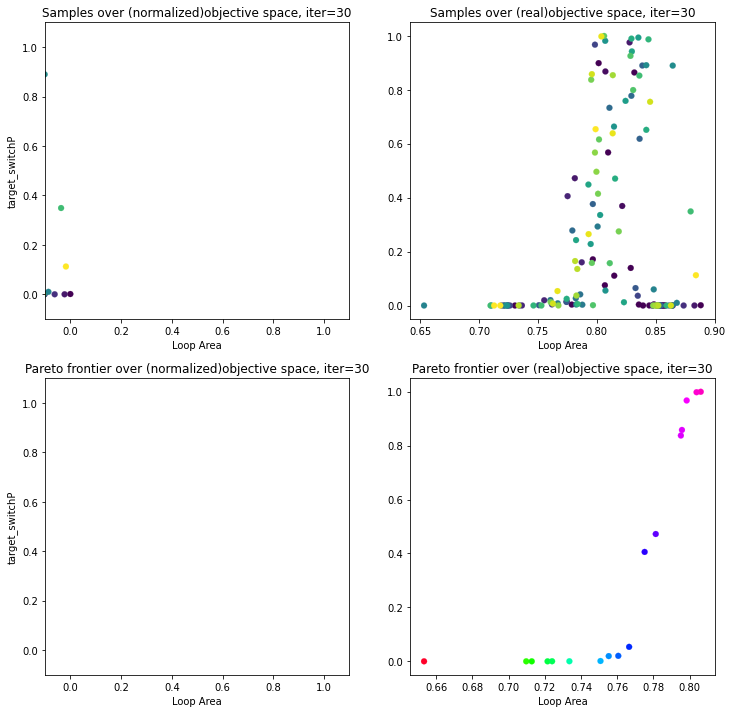

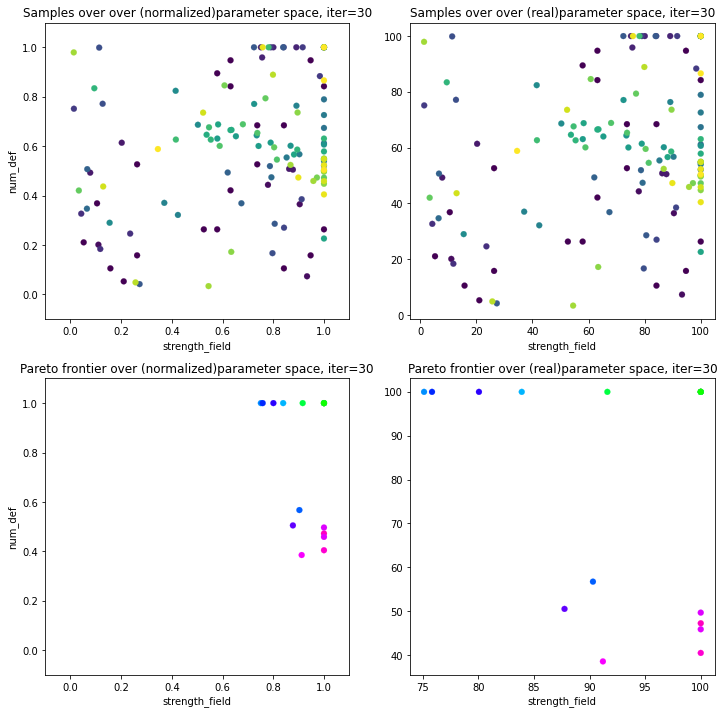

Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #51
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #52
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #53
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #54
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #55
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #56
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #57
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #58
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #59
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


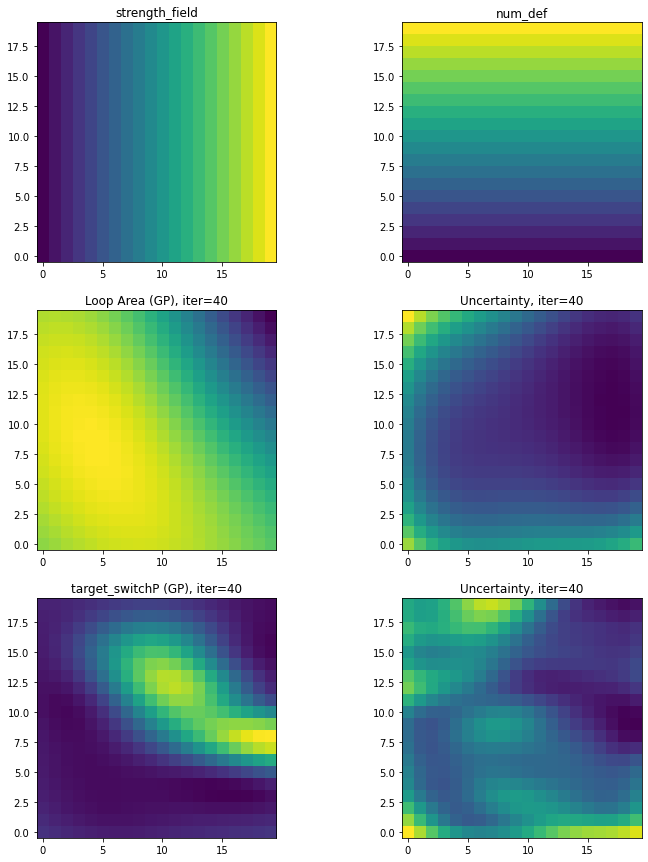

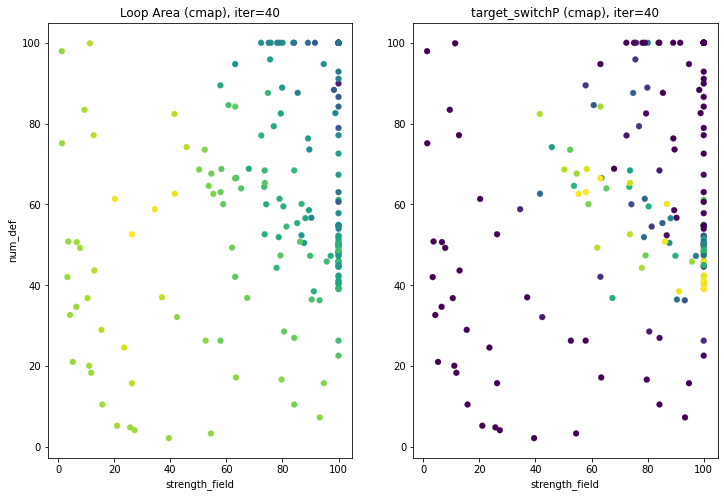

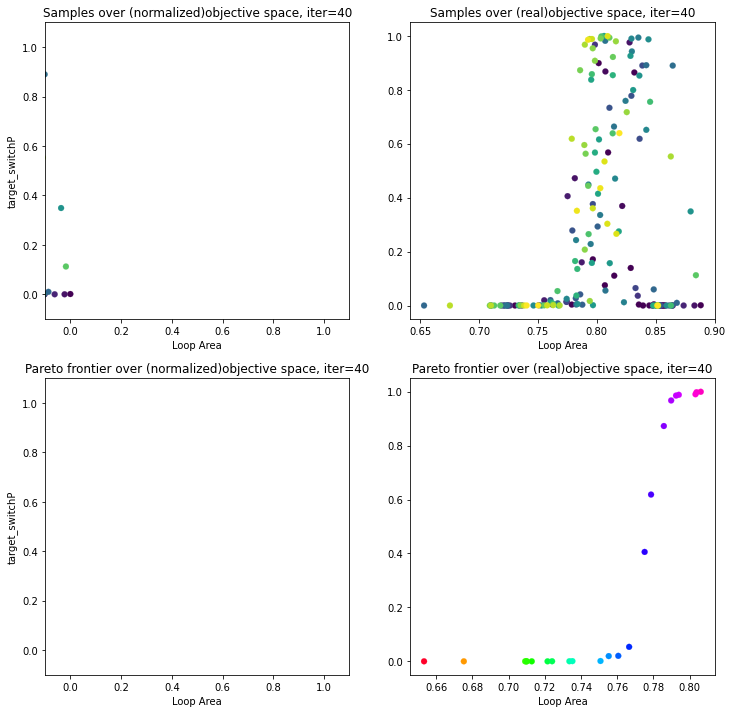

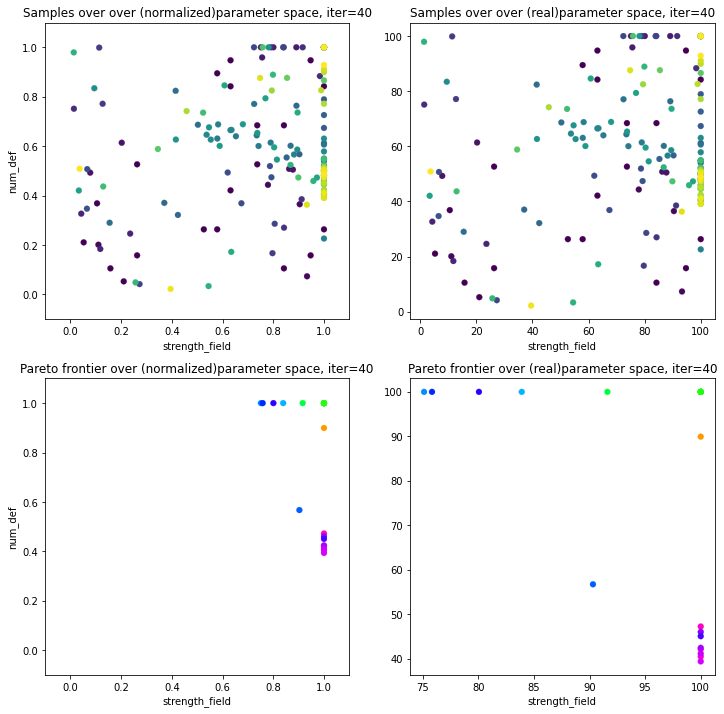

Batch Function eval #60
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #61
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #62
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #63
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #64
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #65
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

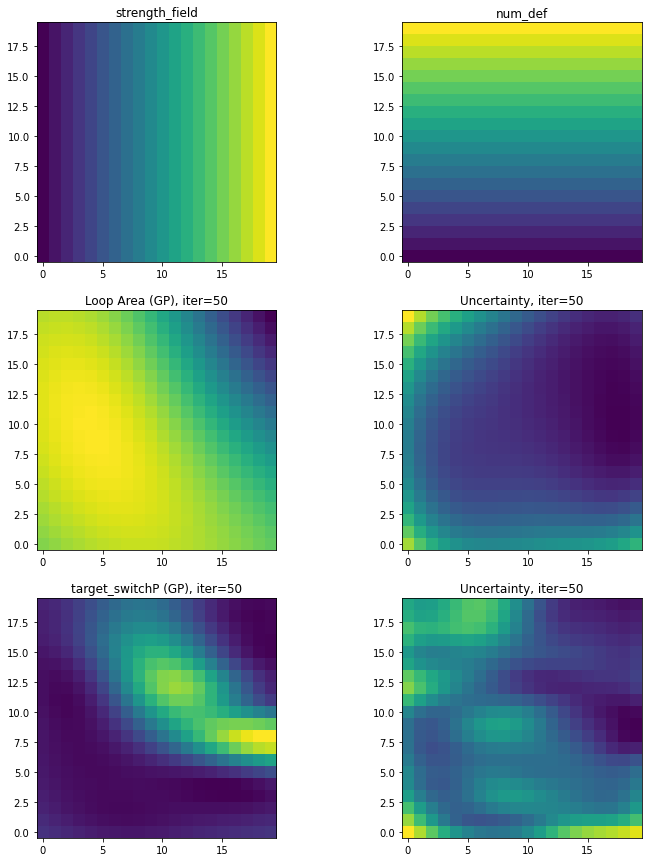

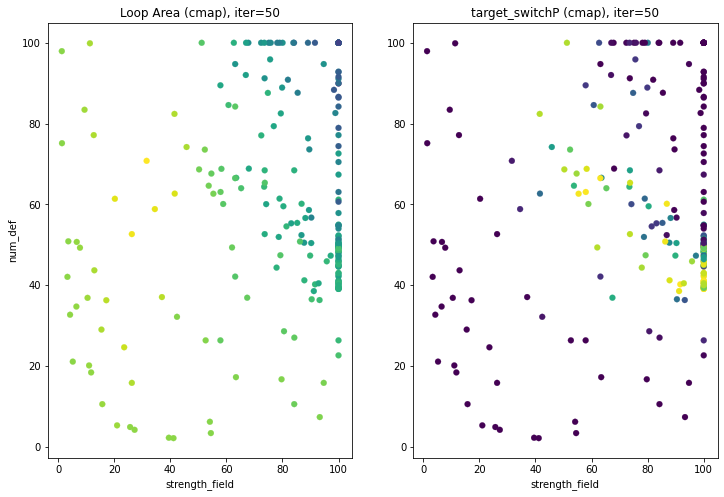

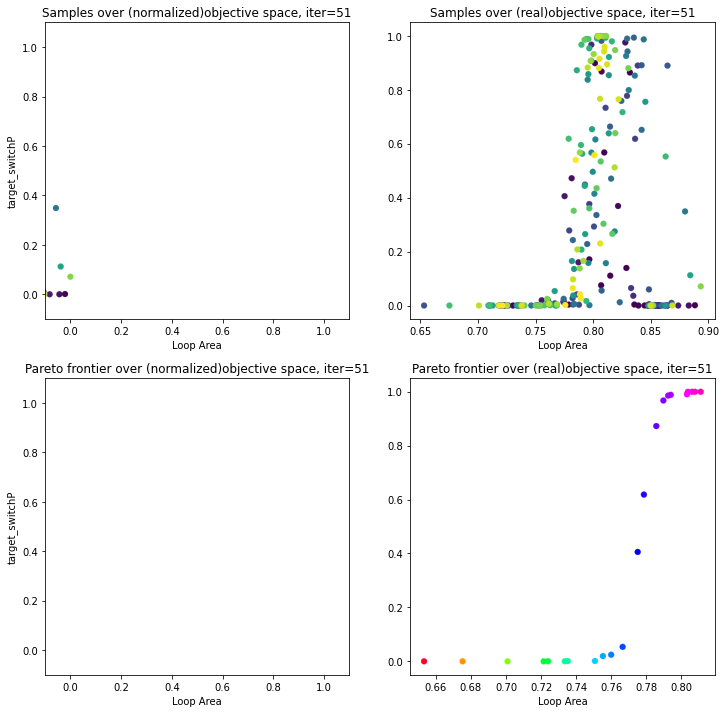

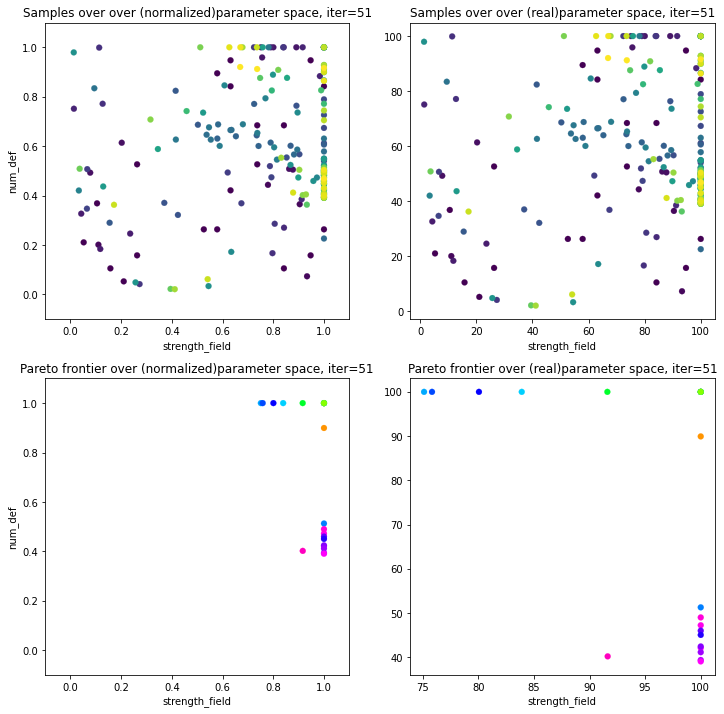

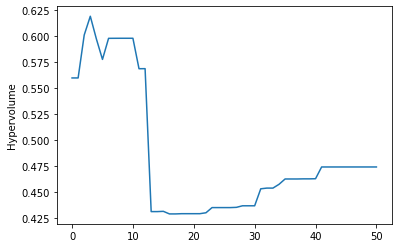

In [14]:
####################### Run BO ##############################

tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4 #For each iteration in BO, how many future samples we select in batch

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParego' -qParEGO
acquisition = 'qParEGO'

#Parameters
param1 = 'strength_field'
param2 = 'num_def'

# Choose any two objectives to do MOO (MOBO)-
# Choose objective 2 either 'switch_P'- swichable polarization or 'target_switchP' - setting a target value for switchable P which the user want to achieve.
obj1 = 'Loop Area'
obj2 = 'target_switchP'

# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['min','max']

#Define parameter space based on above choice of params (2D only)
num_rows =20
num = 20  # Starting samples
N=50

num_def = np.linspace(0, 100, num_rows)
test_num_def = np.linspace(0, 100, num_rows)
strength_field = np.linspace(0, 100, num_rows)
test_strength_field = np.linspace(0, 100, num_rows)

X1 = strength_field
test_X1 = test_strength_field
X2 = num_def
test_X2 = test_num_def


#Call function to run MOBO (physics driven)

#input args in serial: X1- grid array of param 1, X2- grid array of param2, test_X1, test_X2- grid numpy arrays for param X1, X2 (for optional posterior calculations); num_rows, N, BATCH_SIZE- explained in text sections; 
#param1, param2 - string names of parameter 1, 2; obj1, obj2 - string names of objective 1, 2; acquisition - string name as provided in text section for user choice of acquistion function method;
# problem - string array as provided in text section for user choice of maxmimization or minimization of objectives.
MOBO_ferroSim(X1, X2, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem)


<h1> Analysis 2b

Using **qEHVI** acquistion function

Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO- acq func: qEHVI


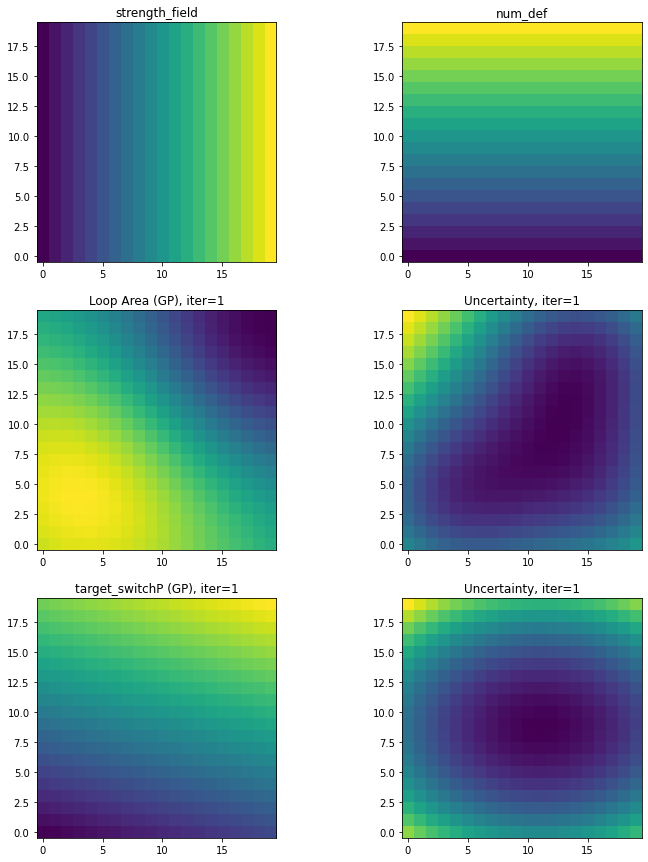

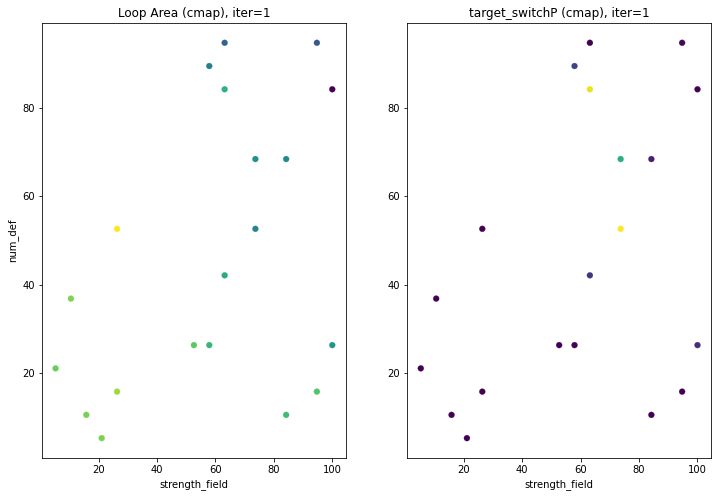

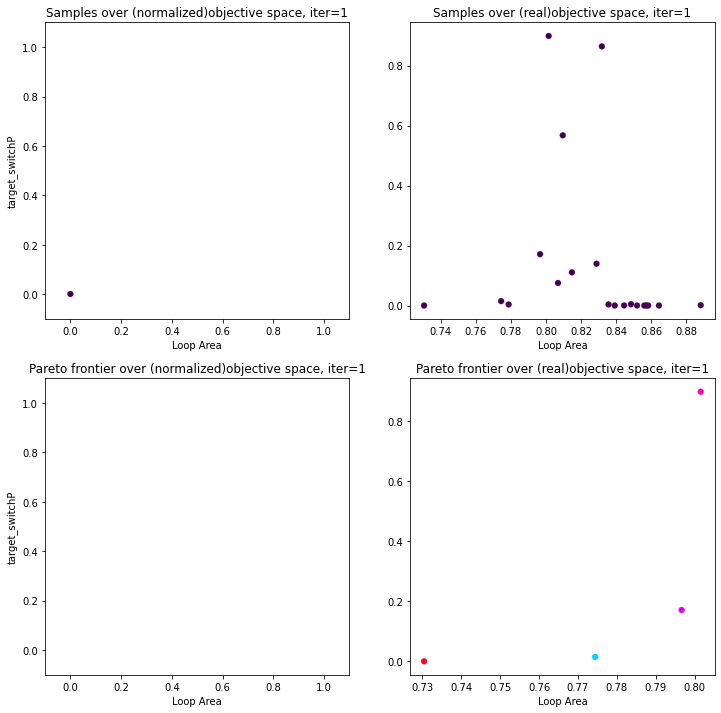

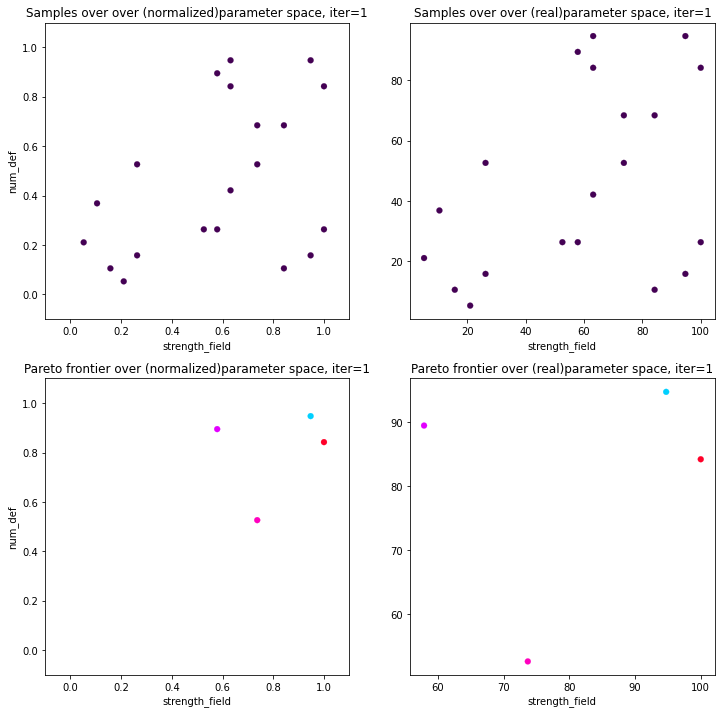

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #27
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #28
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #29
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


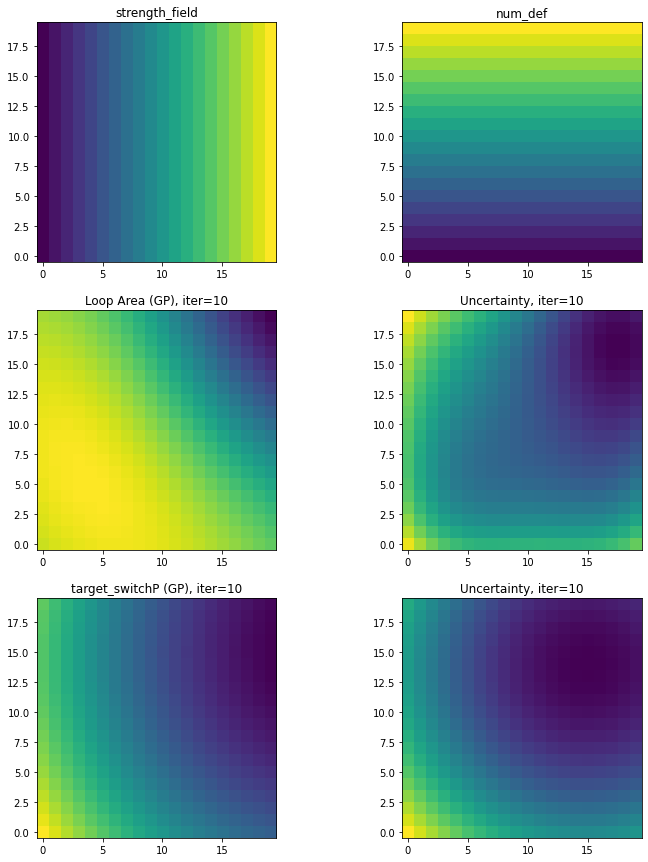

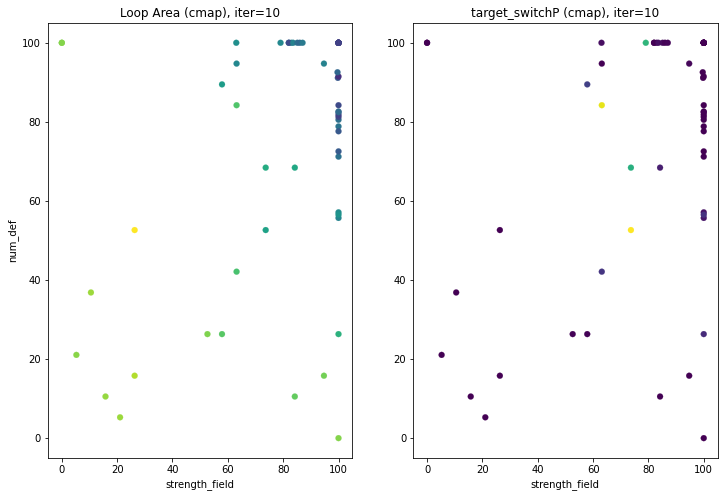

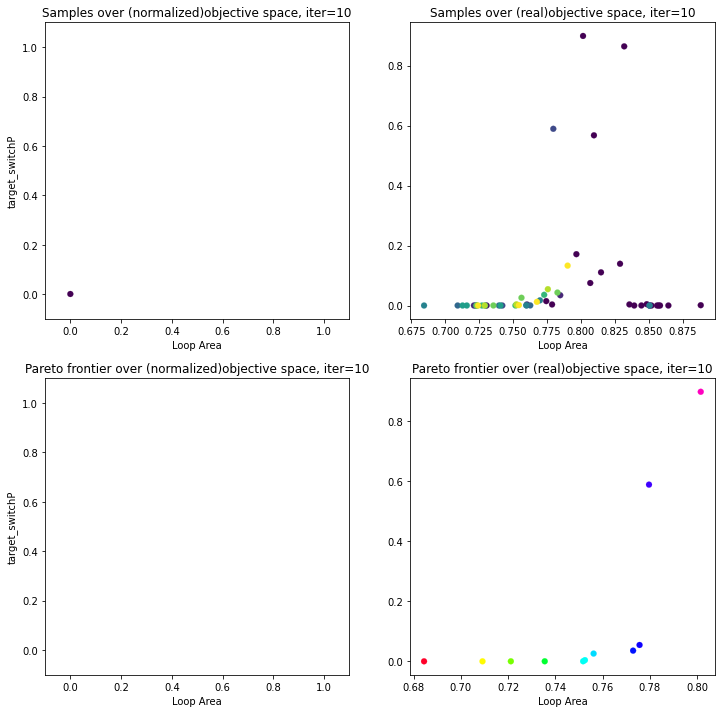

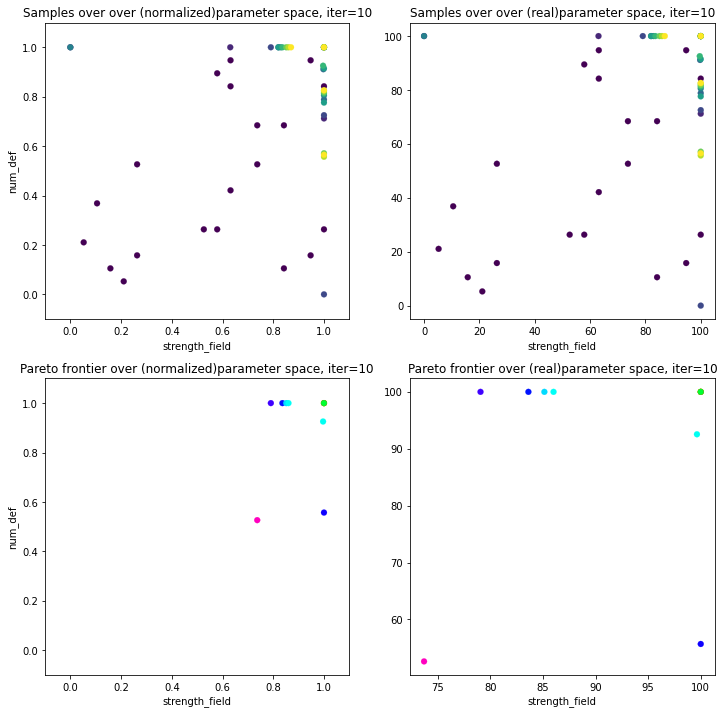

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #36
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #37
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #38
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #39
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


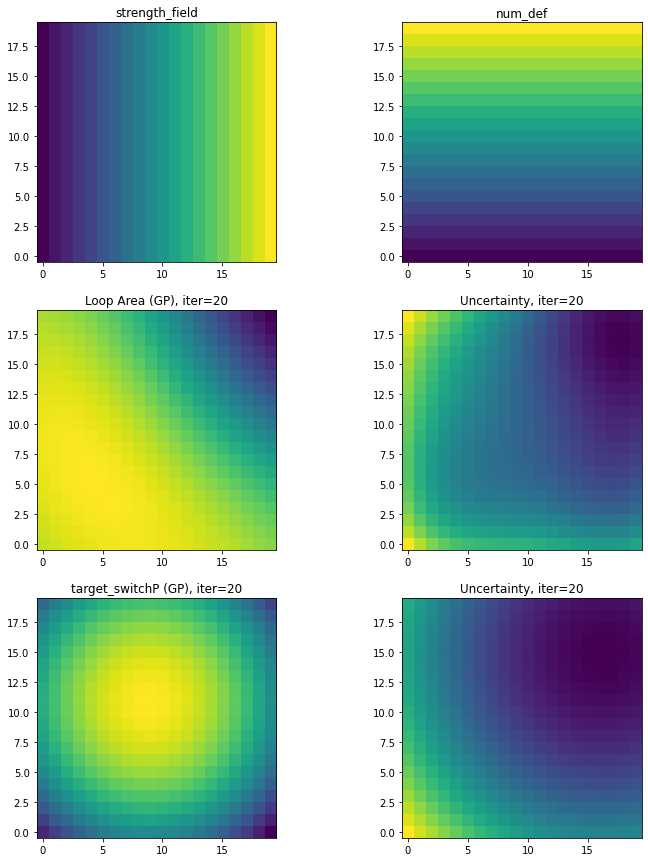

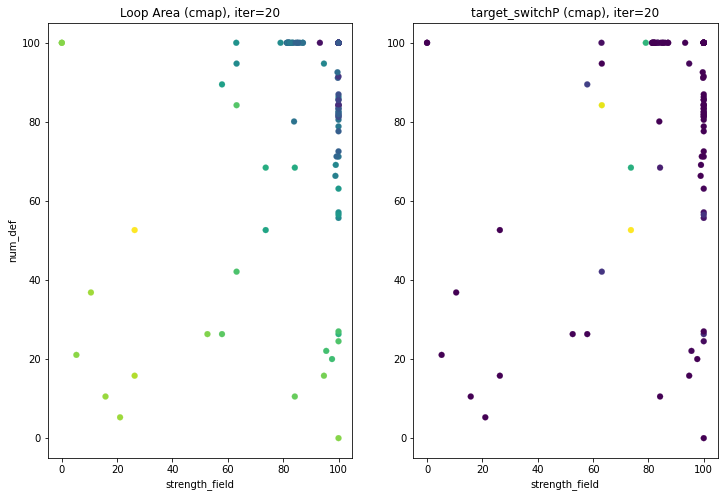

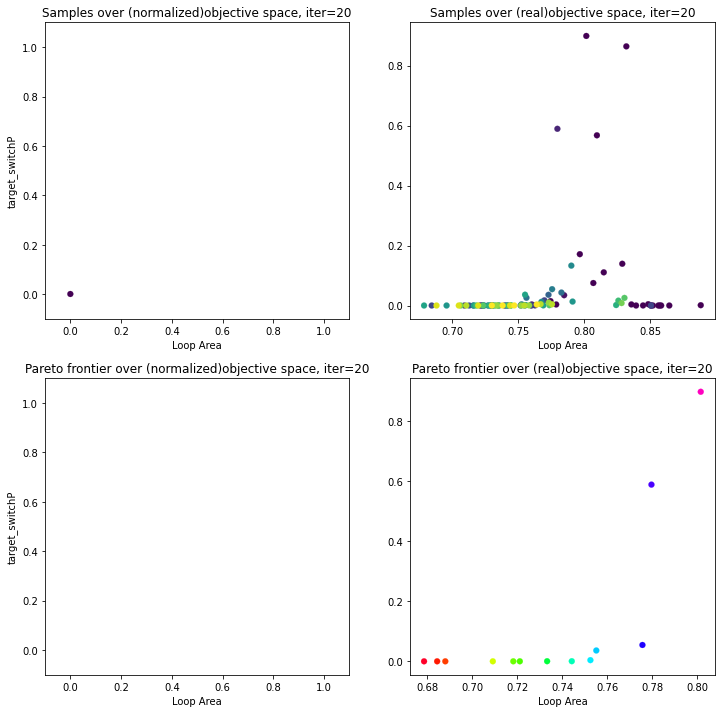

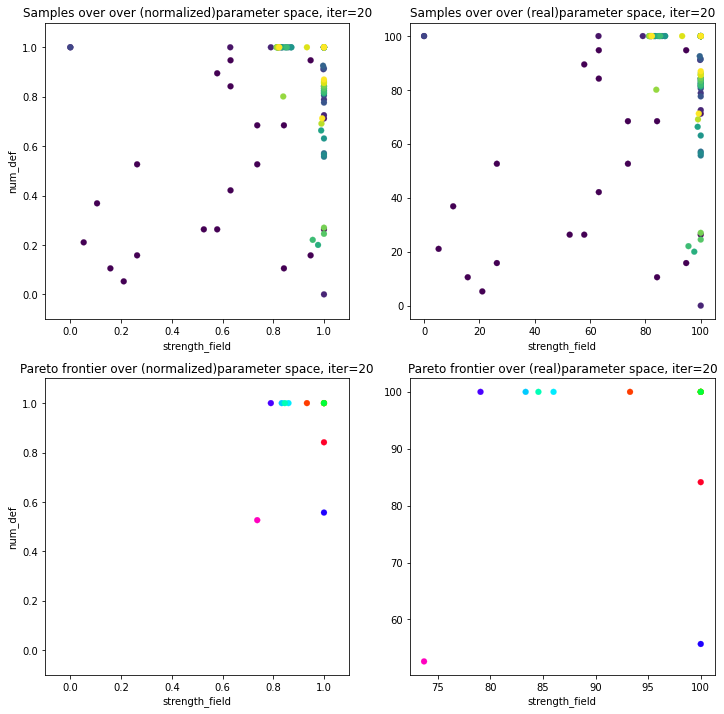

Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #46
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #47
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #48
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #49
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


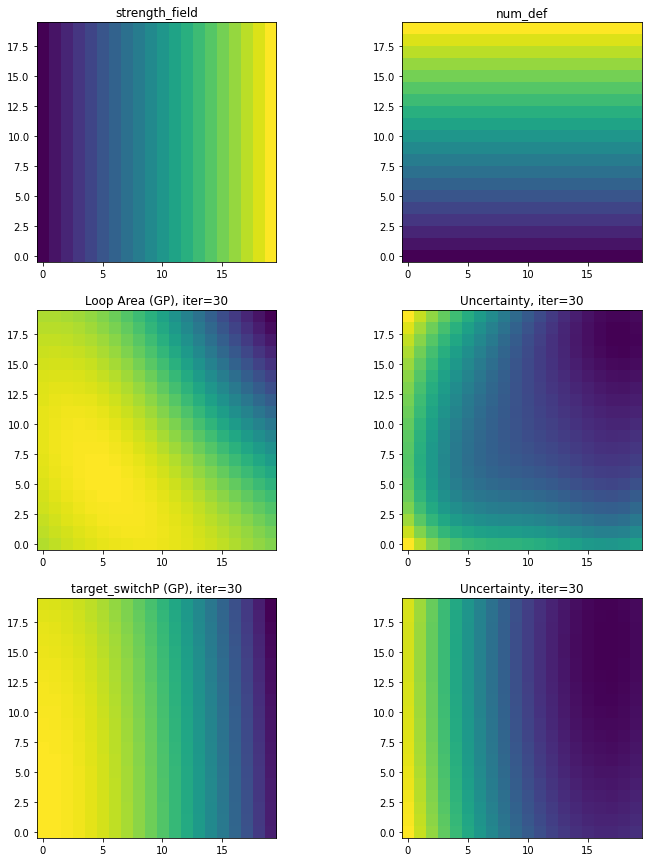

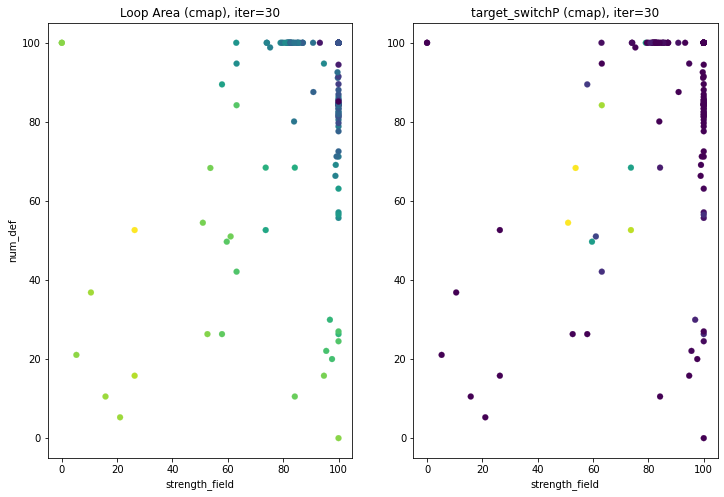

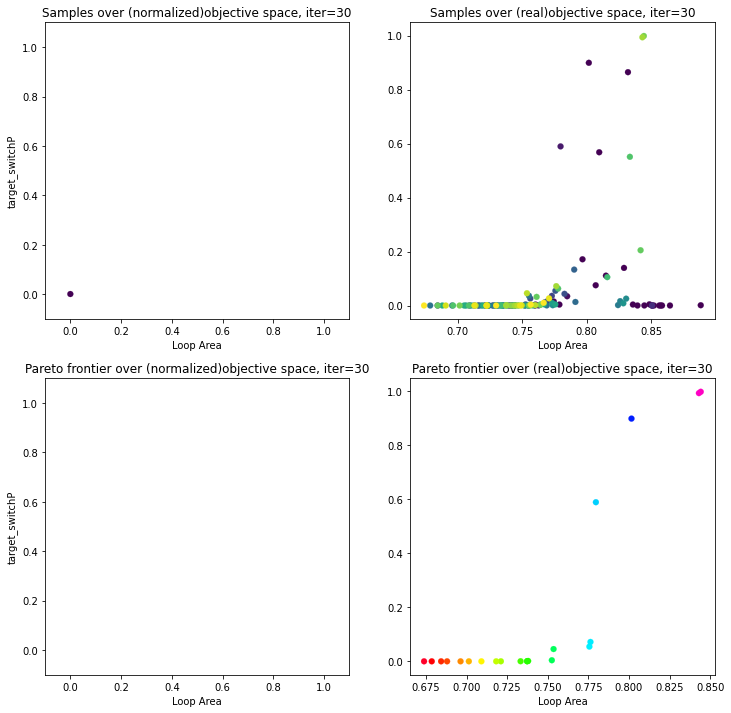

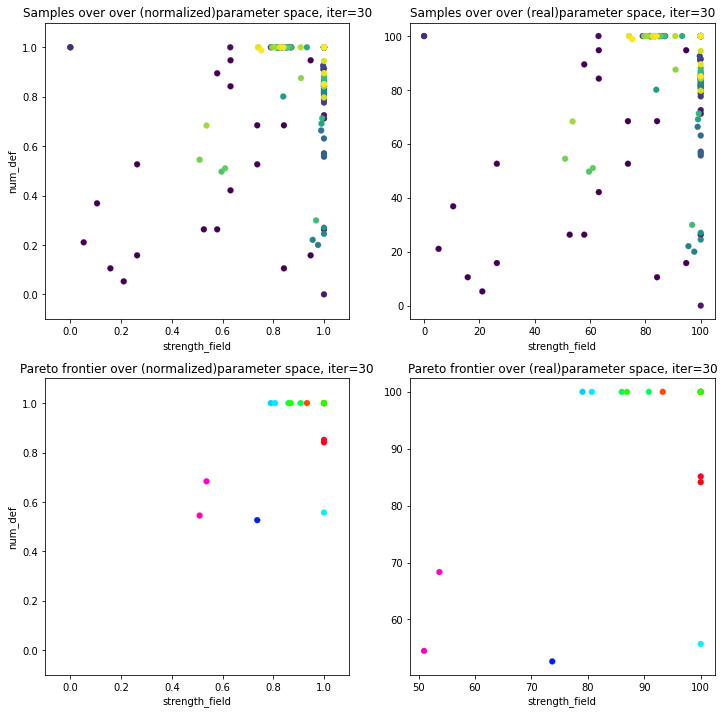

Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #51
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #52
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #53
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #54
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #55
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #56
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #57
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #58
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #59
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


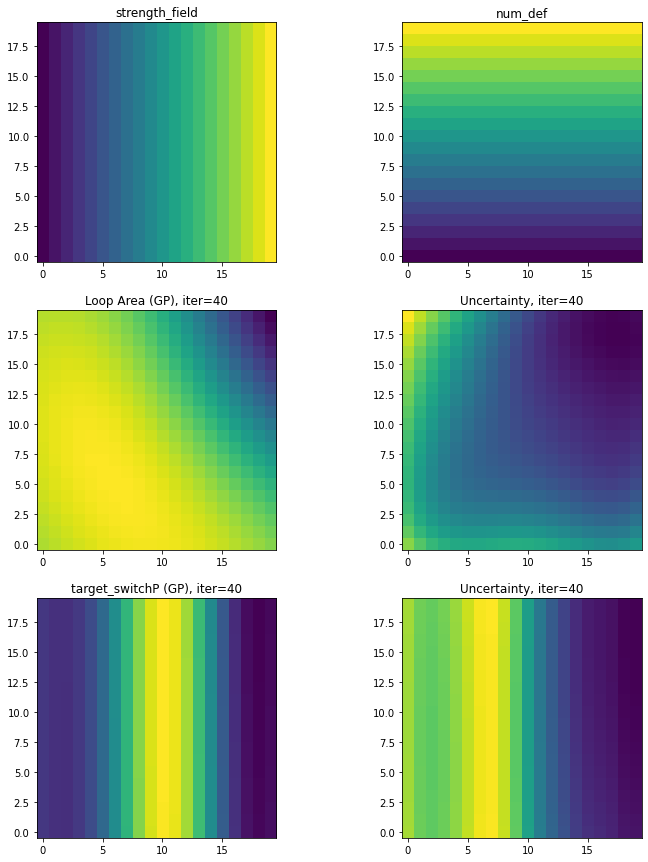

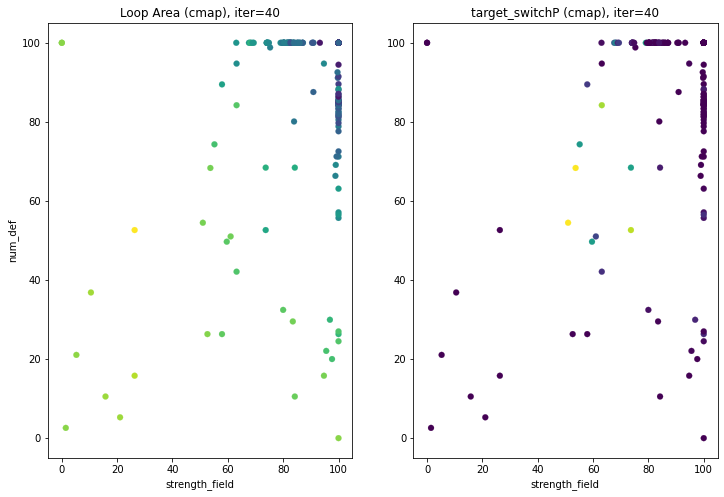

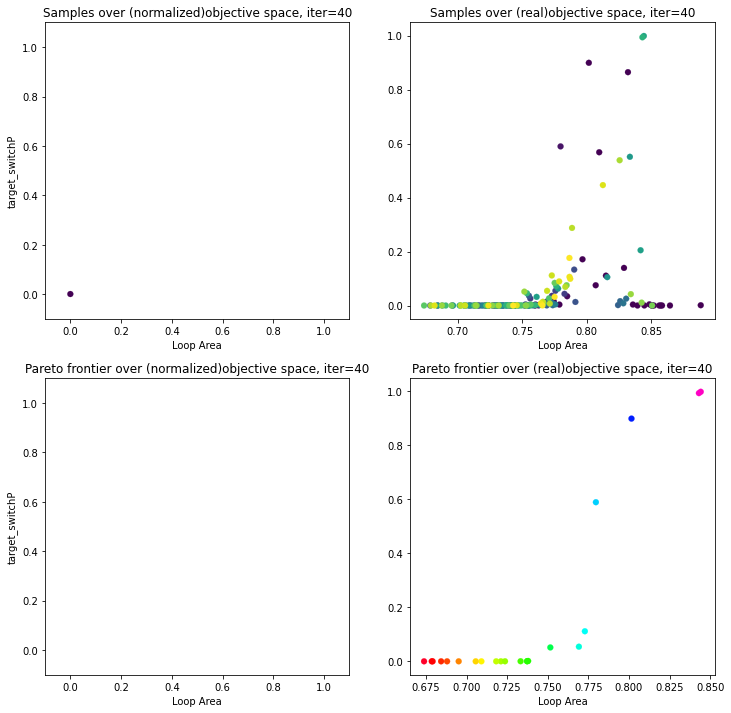

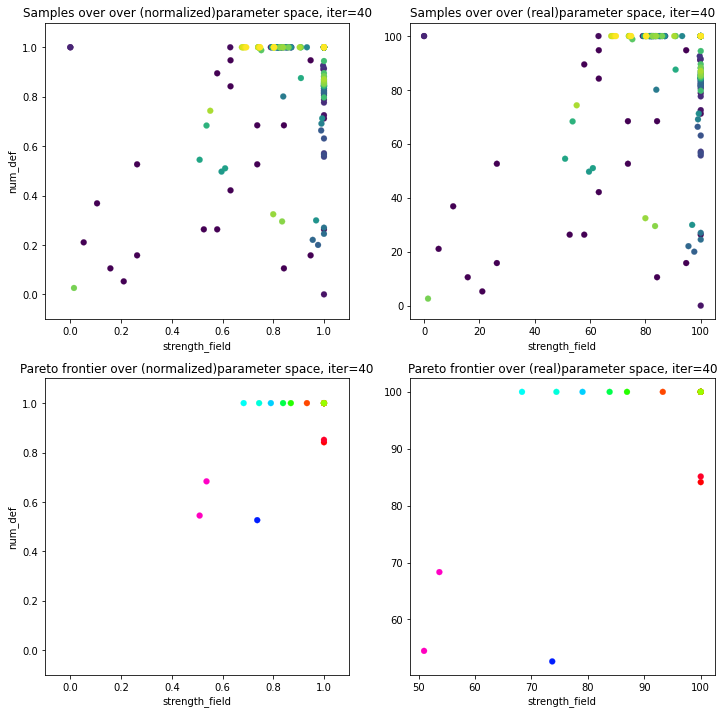

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #60
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #61
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #62
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #63
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #64
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #65
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #66
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #67
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #68
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #69
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #70
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Max. sampling reached, model stopped


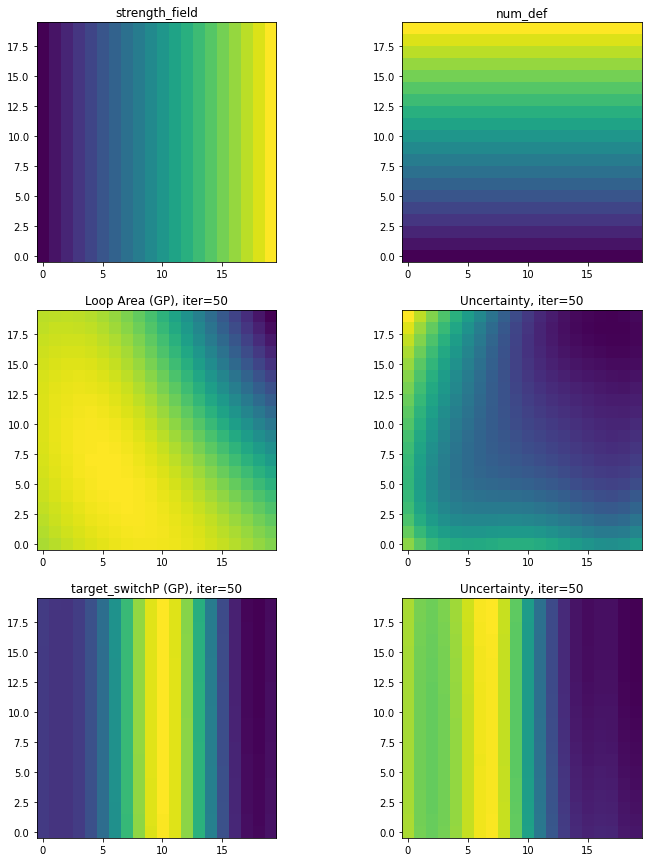

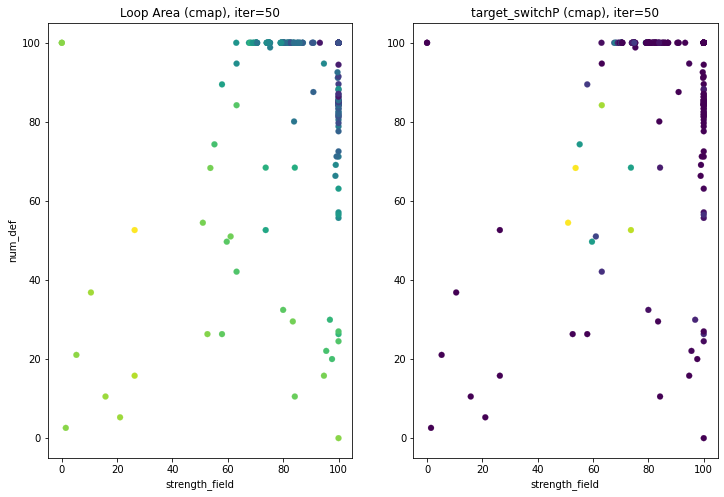

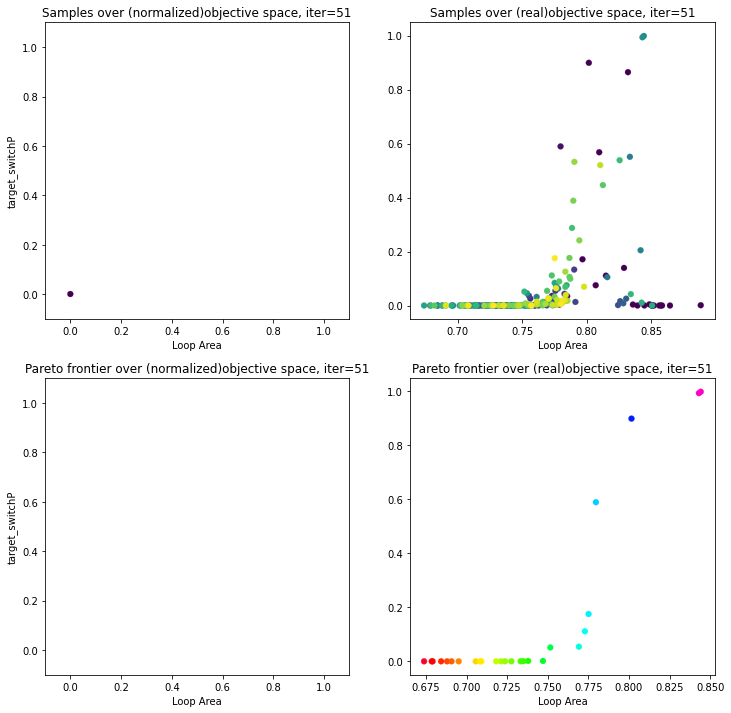

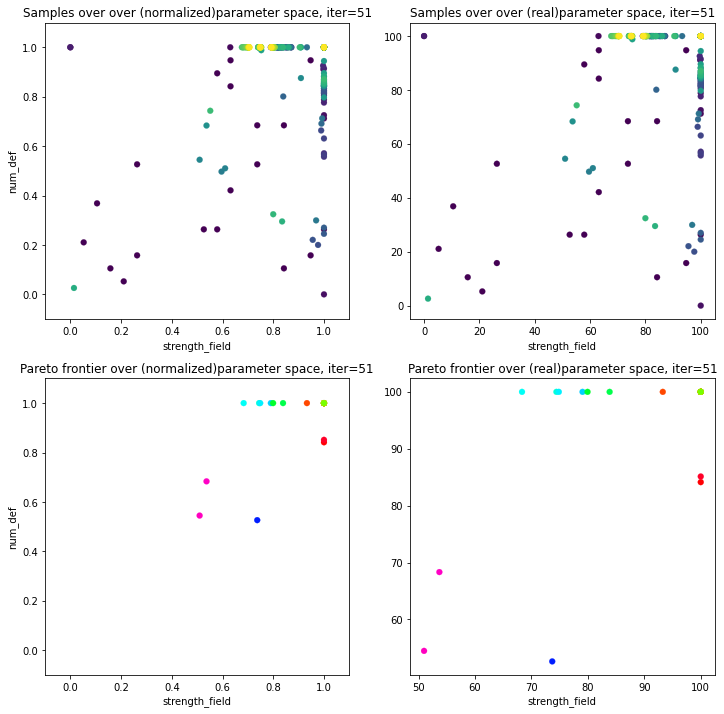

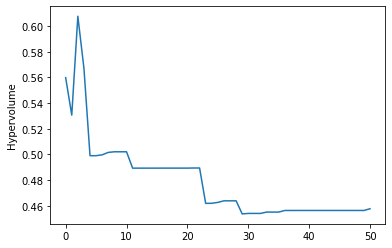

In [15]:
####################### Run BO ##############################

tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4 #For each iteration in BO, how many future samples we select in batch

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParego' -qParEGO
acquisition = 'qEHVI'

#Parameters
param1 = 'strength_field'
param2 = 'num_def'

# Choose any two objectives to do MOO (MOBO)-
# Choose objective 2 either 'switch_P'- swichable polarization or 'target_switchP' - setting a target value for switchable P which the user want to achieve.
obj1 = 'Loop Area'
obj2 = 'target_switchP'

# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['min','max']

#Define parameter space based on above choice of params (2D only)
num_rows =20
num = 20  # Starting samples
N=50

num_def = np.linspace(0, 100, num_rows)
test_num_def = np.linspace(0, 100, num_rows)
strength_field = np.linspace(0, 100, num_rows)
test_strength_field = np.linspace(0, 100, num_rows)

X1 = strength_field
test_X1 = test_strength_field
X2 = num_def
test_X2 = test_num_def


#Call function to run MOBO (physics driven)

#input args in serial: X1- grid array of param 1, X2- grid array of param2, test_X1, test_X2- grid numpy arrays for param X1, X2 (for optional posterior calculations); num_rows, N, BATCH_SIZE- explained in text sections; 
#param1, param2 - string names of parameter 1, 2; obj1, obj2 - string names of objective 1, 2; acquisition - string name as provided in text section for user choice of acquistion function method;
# problem - string array as provided in text section for user choice of maxmimization or minimization of objectives.
MOBO_ferroSim(X1, X2, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem)


Lets see the ground truth of 2 with low-sampling exhaustive search

Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Function eval #21
Function eval #22
Function eval #23
Function eval #24
Function eval #25
Function eval #26
Function eval #27
Function eval #28
Function eval #29
Function eval #30
Function eval #31
Function eval #32
Function eval #33
Function eval #34
Function eval #35
Function eval #36
Function eval #37
Function eval #38
Function eval #39
Function eval #40
Function eval #41
Function eval #42
Function eval #43
Function eval #44
Function eval #45
Function eval #46
Function eval #47
Function eval #48
Function eval #49
Function eval #50
Function eval #51
Function eval #52
Function eval #53
Function eval #54
Function eval #55
Function eval #56
F

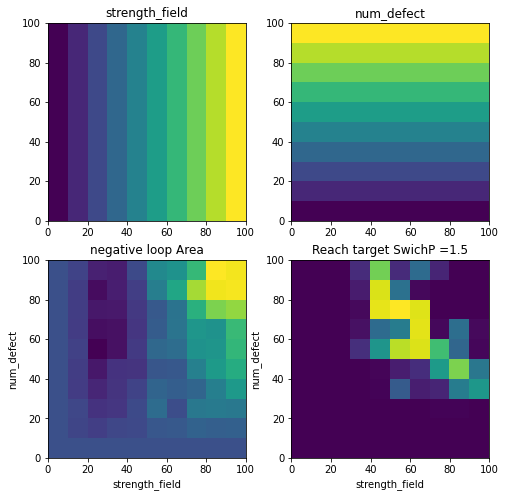

In [13]:
num_rows =10
X1 = np.linspace(0, 100, num_rows)
X2 = np.linspace(0, 100, num_rows)
m=0
X1, X2 = np.meshgrid(X1, X2)
y_true = np.zeros((num_rows, num_rows, 2))
for t1, (x1, x2) in enumerate(zip(X1, X2)):
    for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
        print("Function eval #" + str(m + 1))
        f1, f2 = cal_objective2(10, xx1, int(xx2), rTip=3)
        y_true[t1, t2, 0]= -f1
        y_true[t1, t2, 1]= f2
        m=m+1

_, ax1 = plt.subplots(2, 2, figsize=(8, 8))
ax1[0, 0].imshow(X1, origin='lower', cmap='viridis', extent=[X1.min(), X1.max(), X1.min(), X1.max()])
ax1[0, 1].imshow(X2, origin='lower', cmap='viridis', extent=[X2.min(), X2.max(), X2.min(), X2.max()])
ax1[1, 0].imshow(y_true[:, :, 0], origin='lower', cmap='viridis', extent=[X1.min(), X1.max(), X2.min(), X2.max()])
ax1[1, 1].imshow(y_true[:, :, 1], origin='lower', cmap='viridis', extent=[X1.min(), X1.max(), X2.min(), X2.max()])
ax1[1, 0].set_xlabel("strength_field")
ax1[1, 0].set_ylabel("num_defect")
ax1[1, 1].set_xlabel("strength_field")
ax1[1, 1].set_ylabel("num_defect")
ax1[0, 0].set_title("strength_field")
ax1[0, 1].set_title("num_defect")
ax1[1, 0].set_title("negative loop Area")
ax1[1, 1].set_title("Reach target SwichP =1.5")
plt.show()